# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    accuracy_score,
    cohen_kappa_score,
    hamming_loss
)


import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, Conv1D, Flatten, Concatenate, Dropout
)
from tensorflow.keras.regularizers import l1_l2, l2, l1

import shap

In [2]:
np.random.seed(42)
tf.random.set_seed(42)

# Data Path

The preprocessed datasets were loaded from a specific directory. The directory contains the following 4 CSV files:

- `X_train`, `X_test` (features)
- `y_train`, `y_test` (targets)

Example path:
```python
dataset_path = "/path/to/preprocessed_data/"


In [3]:
# Import the Google Colab drive module to access Google Drive files
from google.colab import drive

# Mount Google Drive to access files stored in it
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# preprocessed_data_path: Path for saving and downloading preprocessed data files
data_path = '/content/drive/MyDrive/Data Science & Decision Making/Preprocessed Data/'

# Initial Exploration of Individual Datasets

This section explores each dataset to understand its structure and key features for analysis.


## Loading All Datasets

All four datasets, **X_train**, **y_train**, **X_test** and **y_test**, are being loaded into the environment.  

Once loaded, each dataset will be examined individually.

In [5]:
# Load the datasets using the defined path
X_train = pd.read_csv(f'{data_path}X_train.csv')
X_test = pd.read_csv(f'{data_path}X_test.csv')
y_train = pd.read_csv(f'{data_path}y_train.csv')
y_test = pd.read_csv(f'{data_path}y_test.csv')

## Displaying All Four Datasets  

The first few rows (**head**) of each dataset are displayed to verify that the data is loading correctly. Additionally, the **shape** of each dataset is checked to understand its dimensions and ensure consistency before merging.  

In [6]:
X_train.head()

,participant_id,EHQ_EHQ_Total,ColorVision_CV_Score,APQ_P_APQ_P_CP,APQ_P_APQ_P_ID,APQ_P_APQ_P_INV,APQ_P_APQ_P_OPD,APQ_P_APQ_P_PM,APQ_P_APQ_P_PP,SDQ_SDQ_Conduct_Problems,...,PC40,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49
0,PFQTomzEXBwj,21,14,4,16,40,21,14,29,4,...,-3.208450,-2.260614,-3.435732,2.167014,-3.981050,3.609948,5.149901,-0.791115,1.751678,-1.287403
1,Z5T4f6OHLTaQ,21,14,3,14,37,22,23,25,3,...,1.232110,-1.578965,-2.742687,-5.529225,4.958709,1.229239,-6.418639,2.204051,-2.718269,-2.246960
2,2AlLf4SXlT1q,21,14,3,12,49,20,14,30,3,...,-1.644410,3.114393,1.941746,0.808115,-0.735024,-0.522410,4.622349,1.000125,0.410817,1.734306
3,DCAeqLbQa173,8,14,4,14,43,22,14,26,0,...,6.824129,5.622534,-3.300351,10.826127,2.907111,-1.103770,3.580812,1.873623,-5.979541,29.481630
4,XC6aisOM0WzL,21,1,3,15,36,18,14,23,1,...,-0.636121,0.907681,0.296508,0.773136,1.774446,-0.378903,6.245098,4.931806,0.847624,-2.574822


In [7]:
X_train.shape

(849, 75)

In [8]:
y_train.head()

,participant_id,ADHD_Outcome,Sex_F
0,PFQTomzEXBwj,1,0
1,Z5T4f6OHLTaQ,1,0
2,2AlLf4SXlT1q,1,1
3,DCAeqLbQa173,0,0
4,XC6aisOM0WzL,1,0


In [9]:
y_train.shape

(849, 3)

In [10]:
X_test.head()

,participant_id,EHQ_EHQ_Total,ColorVision_CV_Score,APQ_P_APQ_P_CP,APQ_P_APQ_P_ID,APQ_P_APQ_P_INV,APQ_P_APQ_P_OPD,APQ_P_APQ_P_PM,APQ_P_APQ_P_PP,SDQ_SDQ_Conduct_Problems,...,PC40,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49
0,M6malGe8P7Ic,16,14,5,19,43,16,13,23,5,...,0.042328,0.133164,-1.258034,-0.528133,1.209805,2.515177,1.424469,1.612481,3.331654,-0.692718
1,XBAesR0BxzjQ,17,5,3,14,38,19,15,29,1,...,0.506541,0.246548,1.229287,-3.186183,2.560323,-1.557586,-1.235853,-2.838652,-1.305051,0.387983
2,PtxdLLjvEhIS,21,14,3,13,47,16,17,28,2,...,-0.331663,2.460719,0.029905,0.049345,3.726150,1.123901,0.330803,-1.276934,-1.533260,2.056757
3,OGitd7RL4GlH,1,6,4,12,45,17,18,26,1,...,-0.902931,1.091429,-0.851562,-2.721745,-2.711082,-0.587119,-1.744503,-1.413515,-1.133640,0.358284
4,X6mFs3EnxuJt,14,14,3,12,42,17,28,23,1,...,-0.037867,-0.172326,0.046520,-1.138162,3.025117,1.630760,-2.373074,1.039927,-0.980066,-3.172548


In [11]:
X_test.shape

(364, 75)

In [12]:
y_test.head()

,participant_id,ADHD_Outcome,Sex_F
0,M6malGe8P7Ic,1,1
1,XBAesR0BxzjQ,1,0
2,PtxdLLjvEhIS,1,0
3,OGitd7RL4GlH,1,0
4,X6mFs3EnxuJt,1,1


In [13]:
y_test.shape

(364, 3)

## Label Overview

To better understand the dataset, we investigate the distribution of key target labels: **Sex**, **ADHD Diagnosis**, and their **combination**. This helps identify class imbalances and guides fair model evaluation.


### Visualizing the Distribution of `label` (Sex and ADHD)

To understand the distribution of the `label` data, we can plot a bar plot for both **Sex** and **ADHD**. This will give us insights into the class balance in the dataset and help identify any potential imbalances between the categories.

#### Key observations:
- **Sex**: The distribution of male and female participants.
- **ADHD**: The count of participants diagnosed with ADHD compared to non-ADHD.

This visualization helps assess the balance between different classes and is important for further analysis and model training.



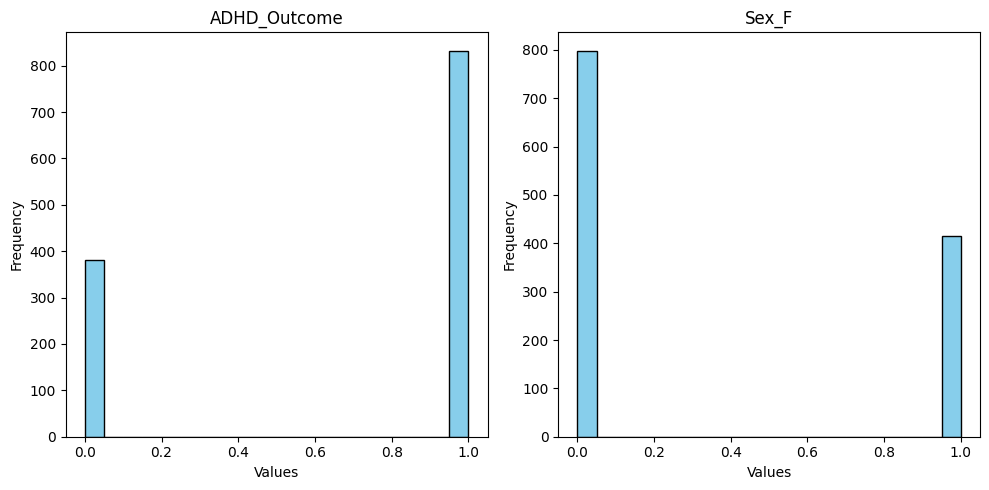

In [14]:
# Step 1: Drop participant_id if present and concatenate y_test and y_train
label = pd.concat([
    y_test.drop(columns=['participant_id'], errors='ignore'),
    y_train.drop(columns=['participant_id'], errors='ignore')
], axis=0)

# Step 2: Set up the number of subplots (one for each column)
num_columns = label.shape[1]

# Step 3: Create subplots
fig, axes = plt.subplots(1, num_columns, figsize=(num_columns * 5, 5))

# Ensure axes is iterable even when there's only one column
if num_columns == 1:
    axes = [axes]

# Step 4: Plot histograms for each column
for i, column in enumerate(label.columns):
    axes[i].hist(label[column], bins=20, color='skyblue', edgecolor='black')
    axes[i].set_title(column)
    axes[i].set_xlabel('Values')
    axes[i].set_ylabel('Frequency')

# Step 5: Adjust layout
plt.tight_layout()
plt.show()

Insight:

After visualizing the **label dataset**, we observed the following:

1. **Gender Distribution**: There are more **male** participants compared to female participants in the dataset. This could indicate an imbalance in the gender distribution, which might impact the model's performance and generalizability. Addressing class imbalance may be considered during model training, such as using class weights or resampling techniques.

2. **ADHD Distribution**: The dataset also shows that **ADHD** cases are more prevalent than non-ADHD cases. This could lead to potential bias in model predictions if the distribution is too skewed. We may need to account for this imbalance through techniques like oversampling the minority class or using specific metrics that handle class imbalance (e.g., ROC AUC, F1-score) during evaluation.

These insights are essential to understanding the dataset and planning appropriate preprocessing or model strategies to ensure balanced predictions.


### Creating a Contingency Table of `Sex` and `ADHD_Outcome`

To better understand the relationship between **Sex** and **ADHD_Outcome**, we create a contingency table. This will show how these two variables are distributed across the dataset.

#### Heatmap Visualization:
A heatmap will provide a clear overview of the relationship between **Sex** and **ADHD_Outcome**, making it easier to visualize the frequency of combinations of the two variables. This will help in understanding any potential patterns or imbalances between the groups.

This step is important for ensuring that the data is balanced and to evaluate if there are any noticeable differences between **Sex** and **ADHD** outcome.



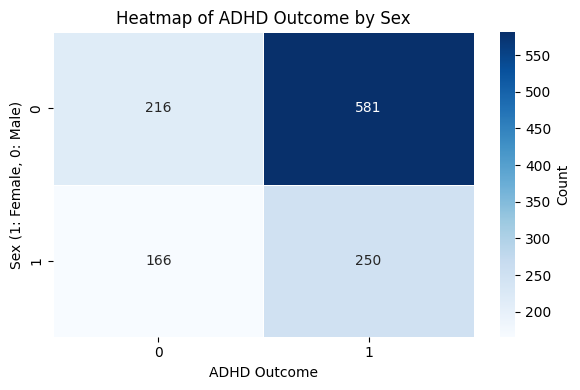

In [15]:
# Create a contingency table of Sex and ADHD_Outcome
contingency_table = pd.crosstab(label['Sex_F'], label['ADHD_Outcome'])

# Create a heatmap to visualize the contingency table
plt.figure(figsize=(6, 4))
sns.heatmap(contingency_table, annot=True, fmt='d', cmap='Blues', cbar_kws={'label': 'Count'}, linewidths=0.5)

# Set chart title and labels
plt.title('Heatmap of ADHD Outcome by Sex')
plt.xlabel('ADHD Outcome')
plt.ylabel('Sex (1: Female, 0: Male)')

# Show the plot
plt.tight_layout()
plt.show()

Insight:

After visualizing the heatmap, we can observe the distribution of **Sex** and **ADHD_Outcome** in the dataset:

- **Male**:  
  - ADHD: 581  
  - Non-ADHD: 216

- **Female**:  
  - ADHD: 250
  - Non-ADHD: 166  

This distribution shows that **males** are more represented in the ADHD category, while **females** show a more balanced distribution between ADHD and non-ADHD outcomes. This insight can help in understanding potential gender-related patterns in ADHD prevalence within the dataset.


# Removing Identity Column from Features and Labels

The dataset contains a unique identifier column, **`participant_id`**, which does not contribute to the model’s learning process. To prevent data leakage and ensure that only relevant features are used for training, we remove this column from both the feature (`X_train`, `X_test`) and label (`y_train`, `y_test`) datasets.

## **Steps Taken:**
1. **Feature Datasets (`X_train`, `X_test`)**: The `participant_id` column is dropped to ensure only predictive features remain.
2. **Label Datasets (`y_train`, `y_test`)**: Although unlikely to contain `participant_id`, we apply `.drop(..., errors='ignore')` to handle cases where it might be present.
   
This ensures that the model is trained on meaningful data while avoiding any influence from an identity-based column.


In [16]:
# Define the column representing participant identities
identity_col = "participant_id"

# Remove the identity column from the training and testing feature sets
X_train_except_identity_col = X_train.drop(columns=[identity_col])  # Drop 'participant_id' from X_train
X_test_identity_col = X_test.drop(columns=[identity_col])  # Drop 'participant_id' from X_test

# Remove the identity column from the target labels (y), if present
y_train_identity_col = y_train.drop(columns=[identity_col], errors='ignore')  # Avoid error if column doesn't exist in y_train
y_test_identity_col = y_test.drop(columns=[identity_col], errors='ignore')  # Avoid error if column doesn't exist in y_test

# Machine Learning Models: Why and How They Help

---

## **Why Logistic Regression?**

- Logistic Regression is a **simple, interpretable baseline model** used for classification tasks.  
- It helps establish a **benchmark performance** before moving on to more complex models like CNN or hybrid architectures.  
- Due to its simplicity, it’s **less prone to overfitting**, especially with smaller datasets or fewer features.

**How This Helps**

- **Interpretability**: Coefficients indicate the direction and strength of feature contributions, making it easier to understand **which features are most predictive**.  
- **Baseline Comparison**: Helps assess whether deep learning models offer significant improvement over traditional methods.  
- **Quick to Train**: Fast training allows for **rapid experimentation** and testing with different subsets or preprocessing pipelines.

---

## **Why Random Forest?**

- Random Forest is an **ensemble learning method** that builds multiple decision trees and combines their outputs for improved accuracy.  
- It works well with both numerical and categorical data and **captures non-linear feature interactions**.  
- It is a more **robust and flexible** alternative to Logistic Regression.

**How This Helps**

- **Feature Importance**: Offers insights into which features matter most for predictions.  
- **Robustness**: Handles outliers, missing values, and high-dimensional data effectively.  
- **Improved Accuracy**: Reduces overfitting by averaging predictions across multiple trees.  
- **Versatility**: Performs well on both binary and multi-label classification tasks.

---

**Why Start with Machine Learning Models?**

- **Interpretability First**: Machine learning models like Logistic Regression and Random Forest provide clear interpretability, helping us understand relationships in the data.
- **Efficient Baseline**: These models are quick to train and tune, allowing for **early performance benchmarking**.
- **Data Insights**: Traditional models help uncover **feature importance**, **class imbalance issues**, and **data preprocessing needs**, which are crucial before building more complex models.
- **Avoid Premature Complexity**: By validating that simpler models are insufficient, we justify the move to deep learning architectures like CNNs or hybrid models.


##  Model Training: Logistic Regression with Feature Selection

We use **Logistic Regression** wrapped in a `MultiOutputClassifier` to handle multi-label prediction (e.g., predicting both ADHD and Sex outcomes).

**Steps:**
1. **Base Model**:  
   A logistic regression model with L2 regularization is defined as the base learner. The `liblinear` solver is chosen for its stability with smaller datasets.

2. **Multi-Output Handling**:  
   `MultiOutputClassifier` is used to apply logistic regression independently to each target label (e.g., ADHD and Sex), enabling multi-label classification.

3. **Feature Selection with RFE**:  
   Recursive Feature Elimination (RFE) is applied to select the **top 50 most relevant features**, reducing dimensionality and improving model generalization.

4. **Training**:  
   The logistic regression model is trained on the reduced feature set after RFE, ensuring that only the most informative features contribute to the final predictions.


In [17]:
def train_multi_output_logistic_model(X_train, y_train_identity_col, X_test, y_test_identity_col,
                                      stratify_col='ADHD_Outcome', n_features=50, n_splits=15, random_state=42):
    """
    Trains a multi-output logistic regression model using RFE for feature selection and cross-validation.
    Also computes precision, recall, and F1-score for each fold.

    Parameters:
        X_train (DataFrame): Training features.
        y_train_identity_col (DataFrame): Training target with multiple output labels (e.g., 'Sex_F', 'ADHD_Outcome').
        X_test (DataFrame): Test features (same features as X_train).
        y_test_identity_col (DataFrame): Test labels.
        stratify_col (str): Column name used for stratified splitting (default: 'ADHD_Outcome').
        n_features (int): Number of features to select via RFE.
        n_splits (int): Number of cross-validation folds.
        random_state (int): Random state for reproducibility.

    Returns:
        model (MultiOutputClassifier): Trained model.
        X_train_rfe (ndarray): Feature-selected training data.
        X_test_rfe (ndarray): Feature-selected test data.
        cv_scores (list): Cross-validation accuracy scores.
        metrics_df (DataFrame): DataFrame containing Precision, Recall, and F1-score per fold.
    """
    # 1. Base model
    base_model = LogisticRegression(penalty='l2', solver='liblinear', max_iter=1000, random_state=random_state)
    multi_output_model = MultiOutputClassifier(base_model)

    # 2. RFE for feature selection (based on one label, e.g., ADHD)
    rfe = RFE(base_model, n_features_to_select=n_features)
    X_train_rfe = rfe.fit_transform(X_train, y_train_identity_col[stratify_col])
    X_test_rfe = rfe.transform(X_test)

    # 3. Cross-validation
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    # DataFrame to store precision, recall, and F1 scores per fold
    metrics_data = {'Fold': [], 'Precision': [], 'Recall': [], 'F1-Score': [], 'Cohen_Kappa': [], 'Hamming_Loss': []}
    cv_scores = []

    for fold_num, (train_idx, val_idx) in enumerate(cv.split(X_train_rfe, y_train_identity_col[stratify_col]), 1):
        X_fold_train, X_fold_val = X_train_rfe[train_idx], X_train_rfe[val_idx]
        y_fold_train = y_train_identity_col.iloc[train_idx]
        y_fold_val = y_train_identity_col.iloc[val_idx]

        multi_output_model.fit(X_fold_train, y_fold_train)
        score = multi_output_model.score(X_fold_val, y_fold_val)
        cv_scores.append(score)

        y_fold_pred = multi_output_model.predict(X_fold_val)

        # Calculate precision, recall, and F1-score for each output
        precision = precision_score(y_fold_val, y_fold_pred, average='micro')
        recall = recall_score(y_fold_val, y_fold_pred, average='micro')
        f1 = f1_score(y_fold_val, y_fold_pred, average='micro')
        kappa = cohen_kappa_score(y_fold_val.values.ravel(), y_fold_pred.ravel())
        hamming = hamming_loss(y_fold_val, y_fold_pred)

        # Append metrics for the current fold
        metrics_data['Fold'].append(fold_num)
        metrics_data['Precision'].append(precision)
        metrics_data['Recall'].append(recall)
        metrics_data['F1-Score'].append(f1)
        metrics_data['Cohen_Kappa'].append(kappa)
        metrics_data['Hamming_Loss'].append(hamming)

    # Convert metrics data to DataFrame
    metrics_df = pd.DataFrame(metrics_data)

    # 4. Final training on full data
    multi_output_model.fit(X_train_rfe, y_train_identity_col)

    return multi_output_model, X_train_rfe, X_test_rfe, metrics_df, rfe, cv_scores

##  Model Training: Random Forest with Multi-Output Classification

We use **Random Forest** wrapped in a `MultiOutputClassifier` to handle multi-label prediction (e.g., predicting both ADHD and Sex outcomes).

**Steps:**
1. **Base Model**:  
   A Random Forest Classifier is defined as the base learner, using 100 trees (`n_estimators=100`) and a maximum depth of 10 for the individual trees. The model benefits from ensemble learning, where multiple trees contribute to the final decision, reducing overfitting and improving robustness.

2. **Multi-Output Handling**:  
   The `MultiOutputClassifier` is used to apply Random Forest independently to each target label (e.g., ADHD and Sex), enabling multi-label classification.

3. **Cross-Validation Setup**:  
   Stratified cross-validation is applied using `StratifiedKFold` to ensure the distribution of target labels is preserved across training and validation folds. This helps in achieving more reliable performance metrics during model evaluation.

4. **Training**:  
   The Random Forest model is trained on each fold of the data, and the model is evaluated using accuracy scores. After cross-validation, the model is trained on the full dataset, leveraging the insights gained from each fold.

5. **Feature Selection and Hyperparameter Tuning**:  
   Hyperparameters like the number of trees (`n_estimators`) and maximum depth of trees (`max_depth`) can be tuned to find the optimal settings that maximize model performance and avoid overfitting.

6. **Final Model**:  
   Once trained, the model is able to predict multiple labels simultaneously, making it well-suited for multi-label classification tasks.

**Why This Helps**:
- **Ensemble Learning**: Random Forest combines multiple decision trees, reducing the likelihood of overfitting and enhancing generalization on unseen data.
- **Cross-Validation**: Cross-validation allows the model to be evaluated on different subsets of data, ensuring that it generalizes well.
- **Feature Importance**: Random Forest provides insights into the relative importance of features, which helps in understanding the most predictive factors for the target labels.


In [18]:
def train_multi_output_random_forest_model(X_train, y_train_identity_col,
                                           stratify_col='Sex_F', n_splits=5,
                                           n_estimators=100, max_depth=10, random_state=42):
    """
    Trains a multi-output Random Forest model with cross-validation and calculates precision, recall, and F1-score.

    Returns:
        model (MultiOutputClassifier): Trained model.
        cv_scores (list): Accuracy scores per fold.
        metrics_df (DataFrame): Precision, Recall, F1-score per fold.
    """
    base_model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        random_state=random_state,
        n_jobs=-1
    )
    multi_output_model = MultiOutputClassifier(base_model)

    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    cv_scores = []

    metrics_data = {'Fold': [], 'Precision': [], 'Recall': [], 'F1-Score': [], 'Cohen_Kappa': [], 'Hamming_Loss': []}

    for fold_num, (train_idx, val_idx) in enumerate(cv.split(X_train, y_train_identity_col[stratify_col]), 1):
        X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_fold_train, y_fold_val = y_train_identity_col.iloc[train_idx], y_train_identity_col.iloc[val_idx]

        multi_output_model.fit(X_fold_train, y_fold_train)
        score = multi_output_model.score(X_fold_val, y_fold_val)
        cv_scores.append(score)

        y_fold_pred = multi_output_model.predict(X_fold_val)

        # Calculate micro-average PRF across all outputs
        precision = precision_score(y_fold_val, y_fold_pred, average='micro', zero_division=0)
        recall = recall_score(y_fold_val, y_fold_pred, average='micro', zero_division=0)
        f1 = f1_score(y_fold_val, y_fold_pred, average='micro', zero_division=0)
        kappa = cohen_kappa_score(y_fold_val.values.ravel(), y_fold_pred.ravel())
        hamming = hamming_loss(y_fold_val, y_fold_pred)

        # Save metrics
        metrics_data['Fold'].append(fold_num)
        metrics_data['Precision'].append(precision)
        metrics_data['Recall'].append(recall)
        metrics_data['F1-Score'].append(f1)
        metrics_data['Cohen_Kappa'].append(kappa)
        metrics_data['Hamming_Loss'].append(hamming)

    # Final training on full dataset
    multi_output_model.fit(X_train, y_train_identity_col)

    metrics_df = pd.DataFrame(metrics_data)

    return multi_output_model, cv_scores, metrics_df

##  Test Set Evaluation and Prediction

After training the model, we evaluate its performance on the test set using a comprehensive set of metrics to assess predictive quality for both **ADHD diagnosis** and **Sex classification**.

---

**Evaluation Metrics**

- **Test Accuracy**:  
  The average accuracy across all target labels is computed using `.score()` on the test set.

- **Label-Wise Performance**:
  For each target (`Sex` and `ADHD`), we compute:
  - **Precision**: The proportion of true positives among all predicted positives.
  - **Recall**: The proportion of true positives among all actual positives.
  - **F1 Score**: The harmonic mean of precision and recall.
  - **Cohen's Kappa**: A measure of agreement between true and predicted labels, adjusted for chance.
  - **Hamming Loss**: The fraction of labels incorrectly predicted.

- **Combined Classification**:  
  We also evaluate the model's ability to jointly predict both labels (`Sex + ADHD`) as a single multi-class label using:
  - **Macro-Averaged Precision, Recall, F1 Score**
  - **Cohen's Kappa**
  - **Combined Hamming Loss**

---

**Prediction Output**

- The model generates predictions on the test set using `.predict()`, producing both label-wise and joint outputs.
- Results are compiled into a DataFrame containing:
  - `participant_id`
  - True and predicted labels for both `Sex` and `ADHD`

This multi-metric approach ensures a well-rounded assessment of model behavior, robustness, and fairness across different demographic and diagnostic categories.


In [19]:
def evaluate_and_predict_model(model, X_test, y_test, threshold=0.5):
    """
    Evaluates a trained multi-output model by computing classification metrics for
    Sex and ADHD prediction, as well as joint correctness (combined accuracy).

    Arguments:
    - model: Trained model to evaluate.
    - X_test: Test data features.
    - y_test: Ground truth labels as a DataFrame with columns ['ADHD_Outcome', 'Sex_F'].
    - threshold: Probability threshold for converting outputs to binary predictions.

    Returns:
    - results_dict: Dict containing correct/incorrect counts per label and combined.
    - y_pred: Binary predicted labels.
    - y_pred_prob: Raw predicted probabilities.
    - X_test: Input test features (returned for convenience).
    - metrics: Dict of performance metrics.
    """
    # Predict probabilities
    y_pred_prob = model.predict(X_test)

    # Ensure output shape is correct
    if y_pred_prob.ndim == 1:
        y_pred_prob = y_pred_prob.reshape(-1, 1)
    if y_pred_prob.shape[1] != y_test.shape[1]:
        raise ValueError("Mismatch between prediction output shape and number of labels.")

    # Convert probabilities to binary predictions using threshold
    y_pred = (y_pred_prob > threshold).astype(int)

    # Extract true values
    y_true = y_test.values
    y_true_adhd = y_test['ADHD_Outcome'].values
    y_true_sex = y_test['Sex_F'].values

    # Predicted values per label
    adhd_index = list(y_test.columns).index('ADHD_Outcome')
    sex_index = list(y_test.columns).index('Sex_F')

    y_pred_adhd = y_pred[:, adhd_index]
    y_pred_sex = y_pred[:, sex_index]

    # Compute metrics per label
    def compute_metrics(y_true, y_pred, label):
        return {
            f'Accuracy_{label}': accuracy_score(y_true, y_pred),
            f'Precision_{label}': precision_score(y_true, y_pred, zero_division=0),
            f'Recall_{label}': recall_score(y_true, y_pred, zero_division=0),
            f'F1_Score_{label}': f1_score(y_true, y_pred, zero_division=0),
            f'Cohen_Kappa_{label}': cohen_kappa_score(y_true, y_pred),
            f'Hamming_Loss_{label}': hamming_loss(y_true, y_pred)
        }

    metrics = {}
    metrics.update(compute_metrics(y_true_sex, y_pred_sex, 'Sex'))
    metrics.update(compute_metrics(y_true_adhd, y_pred_adhd, 'ADHD'))

    # Combined correctness (per sample: both ADHD and Sex correct)
    combined_correct_mask = np.all(y_pred == y_true, axis=1)

    # Count correct/incorrect
    def get_counts(y_true_bin, y_pred_bin, label_name):
        correct = int(np.sum(y_true_bin == y_pred_bin))
        incorrect = int(len(y_true_bin) - correct)
        return {
            'correct': correct,
            'incorrect': incorrect,
            'y_true': y_true_bin,
            'y_pred': y_pred_bin
        }

    results_dict = {
        'Sex_F': get_counts(y_true_sex, y_pred_sex, 'Sex_F'),
        'ADHD_Outcome': get_counts(y_true_adhd, y_pred_adhd, 'ADHD_Outcome'),
        'Combined': {
            'correct': int(np.sum(combined_correct_mask)),
            'incorrect': int(len(combined_correct_mask) - np.sum(combined_correct_mask)),
            'y_true': y_true,
            'y_pred': y_pred
        }
    }

    # Add combined metrics as well
    metrics.update(compute_metrics(y_true.flatten(), y_pred.flatten(), 'Combined'))

    return results_dict, y_pred, y_pred_prob, X_test, metrics

# CNN for Numerical Data + MLP / ANN for Categorical Data

### **Why CNN for Numerical Data (fMRI + Other Numeric Features)?**  
- Convolutional Neural Networks (CNNs) are well-suited for structured numerical data such as **fMRI-derived features** and other numerical inputs.  
- They can detect **local patterns** and **hierarchical relationships** by sliding filters across feature dimensions.  
- This helps extract high-level features useful for classification tasks.

### **Why MLP or ANN for Numerical Data?**  
- Multi-Layer Perceptrons (MLPs) or standard Artificial Neural Networks (ANNs) are commonly used for **tabular categorical data**.  
- They transform categorical inputs (via one-hot encoding or embeddings) into meaningful latent representations through dense layers.  
- Both MLPs and ANNs can model complex, nonlinear interactions between categorical variables.

### **Combining CNN with MLP / ANN**  
- Since the dataset includes a **mix of continuous and categorical variables**, a hybrid architecture is used:
  - **CNN branch** handles continuous inputs (e.g., fMRI, other numeric features).
  - **MLP or ANN branch** handles categorical inputs (e.g., site, ethnicity, parental education).
  - Outputs from both branches are **concatenated** to form a joint representation.
  - Final dense layers use this representation for classification.

### **Why Try Both CNN+MLP and CNN+ANN?**
- **CNN+MLP** provides a more regularized structure with progressive reduction in units.
- **CNN+ANN** can offer flexibility with more layers or units based on architecture tuning.
- Comparing both helps determine which structure better captures the relationship between multimodal data for the classification task.

## Separating Categorical Columns

The following categorical columns are extracted from the dataset to be processed separately using an **MLP (Multi-Layer Perceptron)**:

- `"EHQ_EHQ_Total"`: Handedness score, which has been categorized based on the Edinburgh Handedness Inventory.
- `"Basic_Demos_Study_Site"`: The study site where data was collected.
- `"PreInt_Demos_Fam_Child_Ethnicity"`: Categorical encoding for ethnicity.
- `"PreInt_Demos_Fam_Child_Race"`: Categorical encoding for race.
- `"MRI_Track_Scan_Location"`: Location where the MRI scan was performed.
- `"Barratt_Barratt_P1_Edu"`: Parent 1’s education level.
- `"Barratt_Barratt_P1_Occ"`: Parent 1’s occupation category.
- `"Barratt_Barratt_P2_Edu"`: Parent 2’s education level.
- `"Barratt_Barratt_P2_Occ"`: Parent 2’s occupation category.

These features have been processed separately using embedding layers or one-hot encoding before being fed into the MLP, ensuring that categorical data is properly incorporated into the hybrid CNN-MLP model.


In [20]:
# Define the categorical columns in the dataset
categorical_columns = [
    "EHQ_EHQ_Total",                     # Total score from EHQ questionnaire
    "Basic_Demos_Study_Site",            # Study site where participant data was collected
    "PreInt_Demos_Fam_Child_Ethnicity",  # Ethnicity of the child
    "PreInt_Demos_Fam_Child_Race",       # Race of the child
    "MRI_Track_Scan_Location",           # Location where MRI scan was performed
    "Barratt_Barratt_P1_Edu",            # Education level of Parent 1
    "Barratt_Barratt_P1_Occ",            # Occupation of Parent 1
    "Barratt_Barratt_P2_Edu",            # Education level of Parent 2
    "Barratt_Barratt_P2_Occ"             # Occupation of Parent 2
]

## Ensuring Correct Data Types for Categorical and Numerical Columns

To ensure that the data is properly prepared for model training, we separate the categorical and numerical columns and enforce appropriate data types.

### **Steps Taken:**
1. **Categorical Columns**:
   - Categorical columns are explicitly converted to **strings** using `astype(str)` to ensure consistent handling in models like MLP, which require categorical data in string format (or encoded via embeddings/one-hot encoding).
   - This is applied to both the training (`X_train_cat`) and test (`X_test_cat`) datasets.

2. **Numerical Columns**:
   - Numerical columns (all columns that are not categorical) are converted to **float32** using `astype(np.float32)` for efficient memory usage and to ensure compatibility with machine learning algorithms.
   - This is applied to both the training (`X_train_num`) and test (`X_test_num`) datasets.

This step ensures that categorical data is correctly processed as strings and numerical data is in the appropriate format for the model.


In [21]:
# Extract the categorical columns from X_train and X_test, and convert them to strings
X_train_cat = X_train_except_identity_col[categorical_columns].astype(str)  # Convert selected categorical columns in X_train to string
X_test_cat = X_test_identity_col[categorical_columns].astype(str)  # Convert selected categorical columns in X_test to string

# Extract the numerical columns from X_train and X_test, and convert them to float32 for better memory efficiency
X_train_num = X_train_except_identity_col.drop(columns=categorical_columns).astype(np.float32)  # Convert the remaining numerical columns in X_train to float32
X_test_num = X_test_identity_col.drop(columns=categorical_columns).astype(np.float32)  # Convert the remaining numerical columns in X_test to float32

## CNN + MLP Hybrid Architecture

The model is designed as a hybrid of two deep learning architectures: **Convolutional Neural Networks (CNN)** for numerical data and **Multi-Layer Perceptron (MLP)** for categorical data. This design allows the model to handle both types of data simultaneously, improving its ability to learn from complex relationships in the dataset. Here’s a breakdown of the model:

### 1. CNN for Numerical Data:
- **Purpose**: CNNs are excellent for extracting local patterns in data, making them suitable for sequential or grid-like data. Here, we apply CNN layers to the **numerical data** to capture spatial and temporal patterns that may exist in the features.
  
- **Input Shape**: The model receives numerical data of shape `(input_shape_num[1], 1)`, where `input_shape_num[1]` represents the number of numerical features.
  
- **Layers**:
  - **Conv1D**: A 1D convolutional layer with 64 filters, a kernel size of 3, and ReLU activation. This layer detects features in the input data, which are then passed through a **Dropout** layer to avoid overfitting.
  - **Second Conv1D**: Another convolutional layer with 128 filters, helping the model capture more complex patterns.
  - **Flatten**: Flattens the output from the convolutional layers to feed into dense layers.
  - **Dense**: A fully connected layer with 128 units and ReLU activation. Dropout is applied to prevent overfitting.

- **Why CNN**: CNN is used here because it can automatically learn local feature representations, which is particularly beneficial when the numerical features have a grid-like or sequential structure.

---

### 2. MLP for Categorical Data:
- **Purpose**: MLPs are effective for handling categorical data where the relationships between features might not be local or sequential, but rather represent global dependencies between features.
  
- **Input Shape**: The input for the categorical data is shaped `(input_shape_cat[1],)`, where `input_shape_cat[1]` is the number of categorical features.
  
- **Layers**:
  - **Dense**: A fully connected layer with 128 units and ReLU activation. This allows the model to learn complex representations of categorical features.
  - **Dropout**: Dropout layers are applied after each dense layer to prevent overfitting and ensure that the model generalizes well.
  - **Second Dense**: A layer with 64 units to further refine the model’s representation.

- **Why MLP**: MLPs are ideal for handling categorical data, as they can learn non-linear relationships between the input features. Categorical features often need to be transformed (e.g., using one-hot encoding or embeddings), and MLPs can process these efficiently.

---

### 3. Merging CNN and MLP Outputs:
- **Purpose**: After processing the data through the CNN (for numerical) and MLP (for categorical), the outputs from both branches are concatenated to form a unified representation of both data types.
  
- **Layers**:
  - **Concatenate**: The outputs of both the CNN and MLP branches are merged, ensuring that both numerical and categorical data contribute to the final decision-making process.
  - **Dense Layers**: After concatenation, a series of dense layers with ReLU activation is used to further process the combined representation. These layers are followed by **Dropout** layers to prevent overfitting.

- **Why Merge CNN and MLP**: By merging the outputs of both networks, the model can learn richer representations that take into account the complex relationships between numerical and categorical features simultaneously.

---

### 4. Output Layer:
- **Purpose**: The final layer is used to make predictions, which is typically a classification task in this context.
  
- **Activation Function**: The output layer uses a **sigmoid** activation function, which is commonly used for multi-label classification tasks. This allows the model to output probabilities for each class independently.
  
- **Loss Function**: The model is compiled using **binary cross-entropy** as the loss function, which is suitable for multi-label classification tasks where each output is independent of the others.

---

### Key Hyperparameters:
- **L2 Regularization (`l2_strength`)**: This parameter is used to prevent overfitting by adding a penalty to large weights. A value of `0.01` is typical, but this can be adjusted based on model performance.
  
- **Dropout Rate**: Dropout layers are used to randomly set a fraction of input units to zero during training to prevent overfitting. A rate of `0.3` is used here, which means 30% of the units are dropped at each step.

---

### Model Architecture:

1. **Input Layers**:
   - **Numerical Data**: `num_input` accepts the numerical features.
   - **Categorical Data**: `cat_input` accepts the categorical features.

2. **CNN Branch**:
   - Convolutional layers to process numerical data, followed by dropout and dense layers.

3. **MLP Branch**:
   - Fully connected layers to process categorical data, followed by dropout.

4. **Concatenation**:
   - The outputs of both branches are merged.

5. **Dense Layers**:
   - After merging, dense layers further refine the features before the final output.

6. **Output Layer**:
   - A sigmoid activation function to output multi-label predictions.

---

### Why this Model?

This hybrid model (CNN + MLP) is well-suited for datasets containing both numerical and categorical data. The CNN branch efficiently captures local patterns in numerical data, while the MLP branch can handle categorical relationships, such as those found in demographic or categorical study data. By merging the outputs, the model can leverage both data types in making predictions.

In summary, this architecture is designed to maximize the potential of both CNNs for numerical data and MLPs for categorical data, providing an optimal solution for handling mixed data types in predictive modeling tasks.


In [22]:
def create_model_cnn_mlp(input_shape_num, input_shape_cat, num_classes, l2_strength=0.01, dropout_rate=0.3):
    # CNN for numerical data
    num_input = Input(shape=(input_shape_num[1], 1))  # Input for numerical data
    x = Conv1D(64, kernel_size=3, activation='relu', kernel_regularizer=l2(l2_strength))(num_input)  # First Conv1D layer with L2
    x = Dropout(dropout_rate)(x)  # Dropout after first Conv1D layer
    x = Conv1D(128, kernel_size=3, activation='relu', kernel_regularizer=l2(l2_strength))(x)  # Second Conv1D layer with L2
    x = Flatten()(x)  # Flatten output to feed into dense layer
    cnn_output = Dense(128, activation='relu', kernel_regularizer=l2(l2_strength))(x)  # Fully connected layer after CNN with L2
    cnn_output = Dropout(dropout_rate)(cnn_output)  # Dropout after dense layer in CNN

    # MLP for categorical data
    cat_input = Input(shape=(input_shape_cat[1],))  # Input for categorical data
    y = Dense(128, activation='relu', kernel_regularizer=l2(l2_strength))(cat_input)  # First dense layer for categorical data with L2
    y = Dropout(dropout_rate)(y)  # Dropout after first dense layer in MLP
    y = Dense(64, activation='relu', kernel_regularizer=l2(l2_strength))(y)  # Second dense layer with L2
    mlp_output = Dense(128, activation='relu', kernel_regularizer=l2(l2_strength))(y)  # Fully connected layer after MLP with L2
    mlp_output = Dropout(dropout_rate)(mlp_output)  # Dropout after final MLP layer

    # Concatenate both CNN and MLP outputs
    merged = Concatenate()([cnn_output, mlp_output])  # Merge CNN and MLP outputs
    z = Dense(128, activation='relu', kernel_regularizer=l2(l2_strength))(merged)  # Fully connected layer after merging with L2
    z = Dropout(dropout_rate)(z)  # Dropout after merging CNN and MLP
    z = Dense(64, activation='relu', kernel_regularizer=l2(l2_strength))(z)  # Another dense layer with L2
    z = Dropout(dropout_rate)(z)  # Dropout before final output layer
    z = Dense(num_classes, activation='sigmoid')(z)  # Output layer for multi-label classification

    # Build and compile the model
    model = Model(inputs=[num_input, cat_input], outputs=z)  # Define model with two input layers
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])  # Compile the model

    return model  # Return the compiled model

## CNN + ANN Hybrid Architecture  

The model is designed as a hybrid of two deep learning architectures: **Convolutional Neural Networks (CNN)** for numerical data and **Artificial Neural Networks (ANN)** for categorical data. This structure enables the model to effectively learn from **both continuous (fMRI & other numerical features) and categorical (demographic & metadata) inputs**, improving classification performance.  

---

### 1. CNN for Numerical Data  
- **Purpose**: CNNs are specialized for detecting spatial and hierarchical patterns in structured data. Here, we apply **1D Convolutional layers** to numerical inputs (e.g., fMRI-derived features) to capture relevant relationships.  
- **Input Shape**: `(input_shape_num[1], 1)`, where `input_shape_num[1]` is the number of numerical features.  
- **Layers**:  
  - **Conv1D (64 filters, kernel size 3, ReLU activation)** → Detects local patterns.  
  - **Dropout (0.3)** → Prevents overfitting.  
  - **Conv1D (128 filters)** → Captures higher-level patterns.  
  - **Flatten** → Prepares extracted features for dense layers.  
  - **Dense (128 units, ReLU, Dropout 0.3)** → Learns high-level numerical representations.  
- **Why CNN?** CNNs can **extract complex numerical feature relationships** better than traditional dense layers, improving classification performance.  

---

### 2. ANN for Categorical Data  
- **Purpose**: Unlike MLPs, which often consist of a few dense layers, **ANNs** provide a more flexible and deep structure, making them better suited for handling **high-dimensional categorical data**.  
- **Input Shape**: `(input_shape_cat[1],)`, where `input_shape_cat[1]` is the number of categorical features.  
- **Layers**:  
  - **Dense (256 units, ReLU activation)** → Extracts categorical feature patterns.  
  - **Batch Normalization** → Stabilizes training and improves performance.  
  - **Dropout (0.3)** → Prevents overfitting.  
  - **Dense (128 units, ReLU, Dropout 0.3)** → Further refines categorical representations.  
  - **Dense (64 units, ReLU)** → Final abstraction before merging.  
- **Why ANN?**  
  - Unlike MLPs, ANNs can be **deeper** and **more flexible**, allowing better hierarchical feature learning.  
  - The additional **batch normalization** improves stability, making it ideal for categorical data with diverse distributions.  

---

### 3. Merging CNN and ANN Outputs  
- **Purpose**: To **combine extracted features** from both numerical and categorical data for better classification.  
- **Process**:  
  - CNN and ANN outputs are **concatenated** into a unified representation.  
  - Additional **dense layers** refine the combined features before the final classification.  

---

### 4. Output Layer  
- **Activation Function**: **Sigmoid**, suitable for multi-label classification.  
- **Loss Function**: **Binary cross-entropy**, optimal for independent classification of multiple labels.  

---

### Key Features & Hyperparameters  
- **L2 Regularization (`l2_strength = 0.01`)**: Controls weight growth to prevent overfitting.  
- **Dropout (`0.3`)**: Reduces dependency on specific neurons.  
- **Batch Normalization**: Normalizes activations to improve stability.  

---

### Why CNN + ANN?  
- **CNN handles numerical data more effectively** by capturing spatial and hierarchical patterns.  
- **ANN allows deeper, flexible processing** of categorical data compared to a standard MLP.  
- **By merging CNN and ANN, the model can leverage both numerical and categorical insights**, improving predictive performance.  


In [23]:
def create_model_cnn_ann(input_shape_num, input_shape_cat, num_classes, l2_strength=0.01, dropout_rate=0.3):
    # CNN for numerical data
    num_input = Input(shape=(input_shape_num[1], 1))  # Input for numerical data
    x = Conv1D(64, kernel_size=3, activation='relu', kernel_regularizer=l2(l2_strength))(num_input)  # First Conv1D layer
    x = Dropout(dropout_rate)(x)
    x = Conv1D(128, kernel_size=3, activation='relu', kernel_regularizer=l2(l2_strength))(x)  # Second Conv1D layer
    x = Flatten()(x)
    cnn_output = Dense(128, activation='relu', kernel_regularizer=l2(l2_strength))(x)
    cnn_output = Dropout(dropout_rate)(cnn_output)

    # ANN for categorical data (deeper network than MLP)
    cat_input = Input(shape=(input_shape_cat[1],))  # Input for categorical data
    y = Dense(256, activation='relu', kernel_regularizer=l2(l2_strength))(cat_input)  # First ANN layer
    y = Dropout(dropout_rate)(y)
    y = Dense(128, activation='relu', kernel_regularizer=l2(l2_strength))(y)  # Second ANN layer
    y = Dropout(dropout_rate)(y)
    y = Dense(64, activation='relu', kernel_regularizer=l2(l2_strength))(y)  # Third ANN layer
    y = Dropout(dropout_rate)(y)
    y = Dense(32, activation='relu', kernel_regularizer=l2(l2_strength))(y)  # Fourth ANN layer
    y = Dropout(dropout_rate)(y)
    ann_output = Dense(128, activation='relu', kernel_regularizer=l2(l2_strength))(y)  # Output of ANN

    # Concatenate both CNN and ANN outputs
    merged = Concatenate()([cnn_output, ann_output])
    z = Dense(128, activation='relu', kernel_regularizer=l2(l2_strength))(merged)
    z = Dropout(dropout_rate)(z)
    z = Dense(64, activation='relu', kernel_regularizer=l2(l2_strength))(z)
    z = Dropout(dropout_rate)(z)
    z = Dense(num_classes, activation='sigmoid')(z)

    # Build and compile the model
    model = Model(inputs=[num_input, cat_input], outputs=z)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

## KFold Cross-Validation (Hybrid Model)

We applied **5-fold cross-validation** to assess the performance of our hybrid model combining CNN (for numerical features) and MLP (for categorical features).

**1. Data Splitting**  
- Used `KFold` with `shuffle=True` and `random_state=42` to split the training data into 5 folds.

**2. Preprocessing**  
- **Categorical**: One-hot encoded using `OneHotEncoder`.  
- **Numerical**: Standardized with `StandardScaler` and reshaped for CNN input.

**3. Model Training & Evaluation**  
- For each fold, a new model was trained and evaluated on the validation split.  
- Metrics computed: Accuracy, Precision, Recall, F1-Score, Cohen’s Kappa, and Hamming Loss.

**4. Results**  
- Metrics for each fold were stored and summarized.  
- The final model, encoder, and scaler from the last fold are returned for test-time inference.

**Why KFold?**  
Provides a robust estimate of performance by validating across multiple subsets.


In [24]:
def run_kfold_cv(create_model, X_train_num, X_train_cat, y_train, n_splits=5, epochs = 100, batch_size = 256):
    """
    Perform k-fold cross-validation with preprocessing, training, and evaluation.

    Parameters:
    - create_model: Function that builds and returns a compiled model.
    - X_train_num: DataFrame of numerical input features.
    - X_train_cat: DataFrame of categorical input features.
    - y_train: DataFrame or array of labels (multi-label, one-hot encoded).
    - n_splits: Number of folds for cross-validation (default: 5).
    - epochs: Number of training epochs.
    - batch_size: Batch size for model training .

    Returns:
    - final_model: Trained model from the last fold.
    - final_encoder: OneHotEncoder fitted on the last fold's categorical data.
    - final_scaler: StandardScaler fitted on the last fold's numerical data.
    - metrics_df: DataFrame of evaluation metrics across all folds.
    """


    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Initialize a dictionary to store metrics for each fold
    metrics_data = {
        'Fold': [],
        'Accuracy': [],
        'Precision': [],
        'Recall': [],
        'F1-Score': [],
        'Cohen_Kappa': [],
        'Hamming_Loss': []
    }

    # Placeholders to return the final fold's model, encoder, and scaler
    final_model = None
    final_encoder = None
    final_scaler = None

    # Loop through each fold
    for fold_num, (train_index, val_index) in enumerate(kf.split(X_train_num), 1):
        # Split numerical and categorical data into train/val
        X_train_fold_num = X_train_num.iloc[train_index]
        X_val_fold_num = X_train_num.iloc[val_index]
        X_train_fold_cat = X_train_cat.iloc[train_index]
        X_val_fold_cat = X_train_cat.iloc[val_index]
        y_train_fold = y_train.iloc[train_index]
        y_val_fold = y_train.iloc[val_index]

        # One-hot encode categorical features
        encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        X_train_fold_cat_enc = encoder.fit_transform(X_train_fold_cat)
        X_val_fold_cat_enc = encoder.transform(X_val_fold_cat)

        # Standardize numerical features
        scaler = StandardScaler()
        X_train_fold_num_scaled = scaler.fit_transform(X_train_fold_num)
        X_val_fold_num_scaled = scaler.transform(X_val_fold_num)

        # Convert to float32 for model compatibility
        X_train_fold_num_scaled = X_train_fold_num_scaled.astype(np.float32)
        X_val_fold_num_scaled = X_val_fold_num_scaled.astype(np.float32)
        X_train_fold_cat_enc = X_train_fold_cat_enc.astype(np.float32)
        X_val_fold_cat_enc = X_val_fold_cat_enc.astype(np.float32)

        # Create and train the model
        model = create_model(
            X_train_fold_num_scaled.shape,
            X_train_fold_cat_enc.shape,
            y_train_fold.shape[1]
        )
        model.fit(
            [X_train_fold_num_scaled[..., np.newaxis], X_train_fold_cat_enc],
            y_train_fold,
            epochs=epochs,
            batch_size=batch_size,
            verbose=0  # Silent training
        )

        # Predict probabilities on validation data
        y_val_pred_prob = model.predict([X_val_fold_num_scaled[..., np.newaxis], X_val_fold_cat_enc])
        y_val_pred = (y_val_pred_prob > 0.5).astype(int)  # Convert to binary predictions

        # Compute evaluation metrics
        precision = precision_score(y_val_fold, y_val_pred, average='micro', zero_division=0)
        recall = recall_score(y_val_fold, y_val_pred, average='micro', zero_division=0)
        f1 = f1_score(y_val_fold, y_val_pred, average='micro', zero_division=0)
        hamming = hamming_loss(y_val_fold, y_val_pred)
        kappa = cohen_kappa_score(y_val_fold.values.ravel(), y_val_pred.ravel())
        val_loss, val_acc = model.evaluate(
            [X_val_fold_num_scaled[..., np.newaxis], X_val_fold_cat_enc],
            y_val_fold,
            verbose=0
        )

        # Print fold summary
        print(f"Fold {fold_num} → Acc: {val_acc:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f} | Kappa: {kappa:.4f} | Hamming: {hamming:.4f}")

        # Store metrics for the fold
        metrics_data['Fold'].append(fold_num)
        metrics_data['Accuracy'].append(val_acc)
        metrics_data['Precision'].append(precision)
        metrics_data['Recall'].append(recall)
        metrics_data['F1-Score'].append(f1)
        metrics_data['Cohen_Kappa'].append(kappa)
        metrics_data['Hamming_Loss'].append(hamming)

        # Save model, encoder, and scaler from last fold
        final_model = model
        final_encoder = encoder
        final_scaler = scaler

    # Create a DataFrame from metrics
    metrics_df = pd.DataFrame(metrics_data)

    # Print mean performance across all folds
    print("\n===== Cross-Validation Summary =====")
    print(metrics_df.mean(numeric_only=True).to_string(float_format="%.4f"))

    return final_model, final_encoder, final_scaler, metrics_df

## Test Set Evaluation

After training and validating the model through cross-validation, we assess its final performance on the **test set**.

**1. Preprocessing**
- **Categorical Data**: Transformed using the trained one-hot encoder.
- **Numerical Data**: Standardized using the same scaler from training.
- Both inputs are converted to `float32` to match the model's expectations.

**2. Evaluation**
- The model is evaluated using `model.evaluate()` to compute **test loss** and **test accuracy**.
- Predictions are generated, and binary labels are obtained by thresholding probabilities at 0.5.

**3. Metrics Computed**
- For both **Sex** and **ADHD** targets:
  - **Precision**, **Recall**, **F1-Score**, **Cohen's Kappa**, and **Hamming Loss** are computed.
- A **combined label** is created to assess joint performance on both targets.

**4. Output**
- A detailed `results_df` includes participant ID, true labels, and predictions.
- A dictionary of classification metrics for each target and combined output.
- Final test accuracy is printed to summarize generalization performance.

### Why Test Set Evaluation?
This step is crucial to verify that the model performs well on completely unseen data. It reflects the real-world effectiveness of the model beyond training and validation.


In [25]:
def evaluate_test_set(model, X_test_num, X_test_cat, y_test, encoder, scaler, threshold=0.4):
    """
    Evaluate the trained model on the test dataset for:
    1. ADHD_Outcome only
    2. Sex_F only
    3. Both combined

    Parameters:
    - model: Trained Keras model
    - X_test_num: Test numerical features (DataFrame)
    - X_test_cat: Test categorical features (DataFrame)
    - y_test: Ground truth labels (DataFrame with 'ADHD_Outcome' and 'Sex_F')
    - encoder: OneHotEncoder used on categorical features
    - scaler: StandardScaler used on numerical features
    - threshold: Threshold for converting probabilities to binary predictions (default=0.5)

    Returns:
    - results_dict: Dictionary containing metrics and counts
    - y_pred: Raw predictions (binary)
    - y_pred_prob: Raw prediction probabilities
    - X_test_cat_enc: Encoded categorical features
    - X_test_num_scaled: Scaled numerical features
    """

    # Ensure categorical columns are strings before encoding
    X_test_cat_cleaned = X_test_cat.astype(str)
    X_test_cat_enc = encoder.transform(X_test_cat_cleaned)
    X_test_num_scaled = scaler.transform(X_test_num)

    X_test_cat_enc = X_test_cat_enc.astype(np.float32)
    X_test_num_scaled = X_test_num_scaled.astype(np.float32)

    # Predict
    y_pred_prob = model.predict([X_test_num_scaled[..., np.newaxis], X_test_cat_enc])
    y_pred = (y_pred_prob > threshold).astype(int)

        # Extract true values
    y_true = y_test.values
    y_true_adhd = y_test['ADHD_Outcome'].values
    y_true_sex = y_test['Sex_F'].values

    # Predicted values per label
    adhd_index = list(y_test.columns).index('ADHD_Outcome')
    sex_index = list(y_test.columns).index('Sex_F')

    y_pred_adhd = y_pred[:, adhd_index]
    y_pred_sex = y_pred[:, sex_index]

    # Compute metrics per label
    def compute_metrics(y_true, y_pred, label):
        return {
            f'Accuracy_{label}': accuracy_score(y_true, y_pred),
            f'Precision_{label}': precision_score(y_true, y_pred, zero_division=0),
            f'Recall_{label}': recall_score(y_true, y_pred, zero_division=0),
            f'F1_Score_{label}': f1_score(y_true, y_pred, zero_division=0),
            f'Cohen_Kappa_{label}': cohen_kappa_score(y_true, y_pred),
            f'Hamming_Loss_{label}': hamming_loss(y_true, y_pred)
        }

    metrics = {}
    metrics.update(compute_metrics(y_true_sex, y_pred_sex, 'Sex'))
    metrics.update(compute_metrics(y_true_adhd, y_pred_adhd, 'ADHD'))

    # Combined correctness (per sample: both ADHD and Sex correct)
    combined_correct_mask = np.all(y_pred == y_true, axis=1)

    # Count correct/incorrect
    def get_counts(y_true_bin, y_pred_bin, label_name):
        correct = int(np.sum(y_true_bin == y_pred_bin))
        incorrect = int(len(y_true_bin) - correct)
        return {
            'correct': correct,
            'incorrect': incorrect,
            'y_true': y_true_bin,
            'y_pred': y_pred_bin
        }

    results_dict = {
        'Sex_F': get_counts(y_true_sex, y_pred_sex, 'Sex_F'),
        'ADHD_Outcome': get_counts(y_true_adhd, y_pred_adhd, 'ADHD_Outcome'),
        'Combined': {
            'correct': int(np.sum(combined_correct_mask)),
            'incorrect': int(len(combined_correct_mask) - np.sum(combined_correct_mask)),
            'y_true': y_true,
            'y_pred': y_pred
        }
    }

    # Add combined metrics as well
    metrics.update(compute_metrics(y_true.flatten(), y_pred.flatten(), 'Combined'))

    return results_dict, y_pred, y_pred_prob, X_test_cat_enc, X_test_num_scaled, metrics

# Result Analysis

## Group-wise Prediction Analysis
Evaluate model performance across groups: **Male - ADHD**, **Male - Non-ADHD**, **Female - ADHD**, and **Female - Non-ADHD**. This highlights potential biases or inconsistencies in predictions.

## Performance Metrics (Precision, Recall, F1-Score, Kappa, Hamming Loss)
Report key metrics for **Sex**, **ADHD**, and combined labels:
- **Precision**: Correct positive predictions.
- **Recall**: Correctly identified positives.
- **F1-Score**: Balance between Precision and Recall.
- **Kappa**: Agreement between predictions and truth.
- **Hamming Loss**: Fraction of incorrect predictions.

## Confusion Matrix for Sex, ADHD, and Combined Labels
Confusion matrices show misclassifications for each label, helping assess model accuracy across different categories.

## SHAP (Shapley Additive Explanations)
SHAP values provide insights into the impact of features on model predictions, improving interpretability and transparency in **Sex** and **ADHD** classifications.


## Group-wise Prediction Analysis

We evaluate model performance across four key groups:
- Male – ADHD  
- Male – Non-ADHD  
- Female – ADHD  
- Female – Non-ADHD

**Donut Plot**  
A donut plot visualizes the correct vs. incorrect predictions for each group, making it easy to spot any imbalances (e.g., underperformance on Female–ADHD cases). The donut chart allows us to understand how well the model predicts each group's outcome in a visually engaging way.

**Interpretation**  
This analysis helps determine if the model is fair and accurate across different demographic groups, highlighting any potential biases that may need addressing.

In [26]:
def plot_correct_incorrect_predictions(results_dict):

    y_true_combined = results_dict['Combined']['y_true'].reshape(-1, 2)
    y_pred_combined = results_dict['Combined']['y_pred'].reshape(-1, 2)

    df = pd.DataFrame({
        'sex': y_true_combined[:, 1],
        'adhd': y_true_combined[:, 0],
        'pred_sex': y_pred_combined[:, 1],
        'pred_adhd': y_pred_combined[:, 0]
    })

    label_map = {
        ('0', '1'): 'Male_ADHD',
        ('1', '1'): 'Female_ADHD',
        ('0', '0'): 'Male_NotADHD',
        ('1', '0'): 'Female_NotADHD'
    }

    categories = list(label_map.values())
    results = {cat: {'Correct': 0, 'Incorrect': 0} for cat in categories}

    for _, row in df.iterrows():
        true_label = label_map[(str(int(row['sex'])), str(int(row['adhd'])))]
        pred_label = label_map[(str(int(row['pred_sex'])), str(int(row['pred_adhd'])))]
        if pred_label == true_label:
            results[true_label]['Correct'] += 1
        else:
            results[true_label]['Incorrect'] += 1

    colors = {
        'Correct': '#2ecc71',
        'Incorrect': '#e74c3c'
    }

    fig, axes = plt.subplots(2, 2, figsize=(9, 6))
    axes = axes.flatten()

    for i, (cat, vals) in enumerate(results.items()):
        ax = axes[i]
        data = [vals['Correct'], vals['Incorrect']]
        labels = ['Correct', 'Incorrect']
        explode = (0.03, 0.03)  # slight separation for visual clarity

        wedges, texts, autotexts = ax.pie(
            data,
            labels=labels,
            colors=[colors[l] for l in labels],
            autopct='%1.1f%%',
            startangle=90,
            pctdistance=0.85,
            explode=explode,
            wedgeprops=dict(width=0.4, edgecolor='white')
        )

        # Draw center white circle
        centre_circle = plt.Circle((0, 0), 0.70, fc='white')
        ax.add_artist(centre_circle)

        for autotext in autotexts:
            autotext.set_color('black')
            autotext.set_fontsize(9)
            autotext.set_weight('bold')

        ax.set_title(cat, fontsize=11, weight='bold')

    plt.suptitle('Correct vs Incorrect Predictions per Category', fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

## Correct vs Incorrect Predictions Summary

The function `plot_correct_vs_incorrect_summary(results_dict)` visualizes the number of correct and incorrect predictions for the **Sex_F**, **ADHD_Outcome**, and **Combined** classification tasks. This summary helps to evaluate the model's performance across each task, providing a clear comparison of prediction accuracy.

---

**Why It’s Useful:**
- **Clear Overview**: Shows the distribution of correct vs incorrect predictions for each task.
- **Identifies Strengths and Weaknesses**: Helps identify which tasks the model performs well or poorly on.
- **Visualizes Results**: Easy-to-interpret bar chart displaying task-wise prediction performance.



In [27]:
def plot_correct_vs_incorrect_summary(results_dict):
    """
    Plots the number of correct and incorrect predictions for each classification task
    using results_dict returned from evaluate_test_set().

    Parameters:
    - results_dict: Dictionary containing 'correct' and 'incorrect' values for
                    'Sex_F', 'ADHD_Outcome', and 'Combined'.

    Returns:
    - None (displays plot).
    """

    # Extract values from results_dict
    summary_data = {
        'Sex_F': {
            'Correct': results_dict['Sex_F']['correct'],
            'Incorrect': results_dict['Sex_F']['incorrect']
        },
        'ADHD_Outcome': {
            'Correct': results_dict['ADHD_Outcome']['correct'],
            'Incorrect': results_dict['ADHD_Outcome']['incorrect']
        },
        'Combined': {
            'Correct': results_dict['Combined']['correct'],
            'Incorrect': results_dict['Combined']['incorrect']
        }
    }

    # Convert to DataFrame
    df_summary = pd.DataFrame(summary_data).T

    # Plot with white background
    fig, ax = plt.subplots(figsize=(8, 6))
    df_summary.plot(kind='bar', stacked=True, color=['#4CAF50', '#F44336'], ax=ax)

    ax.set_title('Correct vs Incorrect Predictions per Task', fontsize=16)
    ax.set_ylabel('Count', fontsize=12)
    ax.set_xlabel('Prediction Task', fontsize=12)

    # Customize the legend box to have a white background
    ax.legend(loc='upper right', fontsize=10, frameon=True, facecolor='white')

    # Annotate bars with counts
    for p in ax.patches:
        height = p.get_height()
        if height > 0:
            ax.annotate(f'{int(height)}',
                        (p.get_x() + p.get_width() / 2., p.get_y() + height / 2),
                        ha='center', va='center', fontsize=10, color='white')

    ax.set_facecolor('white')  # Set background to white
    plt.xticks(rotation=0)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

## Performance Metrics (Precision, Recall, F1-Score, Kappa, Hamming Loss)

We report key performance metrics to evaluate the model's ability to predict **Sex**, **ADHD**, and their combination. The metrics include **Precision**, **Recall**, **F1-Score**, **Cohen's Kappa**, and **Hamming Loss**.

- **Precision**: Measures how many predicted positives were actually correct.
- **Recall**: Indicates how well the model identifies all actual positives.
- **F1-Score**: Harmonic mean of precision and recall — balances both metrics.
- **Cohen's Kappa**: Evaluates agreement between predicted and true labels, accounting for chance.
- **Hamming Loss**: Measures the fraction of incorrect labels compared to the total.

---

**Why These Metrics?**
Accuracy alone can be misleading, especially with imbalanced classes. These metrics provide a more comprehensive view of model performance, especially for detecting minority classes like **ADHD in females**. They help assess the model's **ability to handle imbalances** and its overall effectiveness in classification tasks.

### Plotting Cross-Validation Metrics

The function `plot_cv_metrics(metrics_df)` visualizes model performance across folds during **K-Fold Cross-Validation**. It plots key metrics like **Precision**, **Recall**, **F1-Score**, **Cohen's Kappa**, and **Hamming Loss** to track model consistency.

---



**Why It’s Useful:**
- Tracks **model stability** and identifies any **performance inconsistencies** across folds.
- Helps spot **weak folds** and **trade-offs** between different metrics.


In [28]:
def plot_cv_metrics(metrics_df):
    """
    Plots cross-validation metrics (Precision, Recall, F1, Kappa, Hamming) across folds.

    Parameters:
        metrics_df (DataFrame): DataFrame containing metrics per fold.
    """
    # Set the background color and theme
    background_color = '#e2f0fe'
    sns.set_theme(style="whitegrid", rc={"axes.facecolor": background_color})

    plt.figure(figsize=(12, 6))
    metrics_long = metrics_df.melt(id_vars='Fold',
                                   value_vars=['Precision', 'Recall', 'F1-Score', 'Cohen_Kappa', 'Hamming_Loss'],
                                   var_name='Metric', value_name='Score')

    sns.lineplot(data=metrics_long, x='Fold', y='Score', hue='Metric', marker='o')
    plt.title('Cross-Validation Metrics per Fold')
    plt.ylim(0, 1)
    plt.grid(True)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

### Plotting Performance Metrics

The function `plot_metrics(metrics)` generates a **bar plot** to visualize model performance based on key metrics such as **Precision**, **Recall**, **F1-Score**, **Cohen's Kappa** and **Hamming Loss**. These metrics are crucial for evaluating the model's effectiveness on the **Sex**, **ADHD**, and **Combined** labels.

---

**Why It’s Useful:**
- Provides a **clear comparison** of different performance metrics.
- Helps identify the **relative strengths** and **weaknesses** of the model across various evaluation metrics.
- **Visualizes trade-offs** between metrics, making it easier to understand overall model performance.


In [29]:
def plot_metrics(metrics):
    metrics_df = pd.DataFrame(list(metrics.items()), columns=['Metric', 'Score'])

    # Add numbering to metric labels
    metrics_df['Metric'] = [f"{i+1}. {m}" for i, m in enumerate(metrics_df['Metric'])]

    # Seaborn and Matplotlib aesthetics
    sns.set_style("whitegrid")  # Subtle grid
    plt.figure(figsize=(11, 6), facecolor='white')

    # Create barplot
    ax = sns.barplot(
        x='Score',
        y='Metric',
        data=metrics_df,
        palette='viridis',
        edgecolor='gray'
    )

    # Annotate scores
    for i, (score, label) in enumerate(zip(metrics_df['Score'], metrics_df['Metric'])):
        ax.text(score + 0.015, i, f"{score:.2f}", va='center', ha='left', fontsize=10, color='black')

    # Style titles and labels
    plt.title('Precision, Recall, and F1-Score for Sex, ADHD, and Combined Label', fontsize=16)
    plt.xlabel('Score', fontsize=12)
    plt.ylabel('')
    plt.xlim(0, 1.05)

    # Make grid more subtle
    ax.xaxis.grid(True, linestyle='--', linewidth=0.5)
    ax.yaxis.grid(False)

    # Despine and layout
    sns.despine(left=True, bottom=True)
    plt.tight_layout()
    plt.show()

## Confusion Matrix for Sex, ADHD, and Combined Labels

The **Confusion Matrix** shows how well the model's predictions match the actual values for **Sex**, **ADHD**, and **combined** labels, indicating true positives, true negatives, false positives, and false negatives.

---

**Why It’s Useful:**
- Provides insights into **misclassifications** and **model performance**.
- Highlights issues like class imbalances, especially in challenging categories like **ADHD in females**.


In [30]:
def plot_confusion_matrices(results_dict):
    """
    Plots confusion matrices for Sex, ADHD, and Combined (Sex + ADHD) classifications.

    Parameters:
    - results_dict: Dictionary from evaluate_test_set() with keys 'Sex_F', 'ADHD_Outcome', and 'Combined'.

    Returns:
    - None (displays the confusion matrix plots).
    """
    # Extract true/predicted values
    y_true_sex = results_dict['Sex_F']['y_true']
    y_pred_sex = results_dict['Sex_F']['y_pred']

    y_true_adhd = results_dict['ADHD_Outcome']['y_true']
    y_pred_adhd = results_dict['ADHD_Outcome']['y_pred']

    # Combined labels
    y_true_combined = results_dict['Combined']['y_true'].reshape(-1, 2)
    y_pred_combined = results_dict['Combined']['y_pred'].reshape(-1, 2)

    # Create readable combined labels
    label_map = {
        '0_0': 'Male_NoADHD',
        '0_1': 'Male_ADHD',
        '1_0': 'Female_NoADHD',
        '1_1': 'Female_ADHD'
    }
    combined_true_labels = [label_map[f"{int(sex)}_{int(adhd)}"] for adhd, sex in y_true_combined]
    combined_pred_labels = [label_map[f"{int(sex)}_{int(adhd)}"] for adhd, sex in y_pred_combined]

    # Encode combined labels
    encoder = LabelEncoder()
    encoder.fit(list(label_map.values()))
    y_true_combined_enc = encoder.transform(combined_true_labels)
    y_pred_combined_enc = encoder.transform(combined_pred_labels)

    # Setup subplots
    fig, axs = plt.subplots(1, 3, figsize=(20, 5))

    # 1. Sex Confusion Matrix
    cm_sex = confusion_matrix(y_true_sex, y_pred_sex)
    disp_sex = ConfusionMatrixDisplay(confusion_matrix=cm_sex, display_labels=['Male', 'Female'])
    disp_sex.plot(ax=axs[0], values_format='d', cmap='cividis')
    axs[0].set_title('Sex')
    axs[0].grid(False)

    # 2. ADHD Confusion Matrix
    cm_adhd = confusion_matrix(y_true_adhd, y_pred_adhd)
    disp_adhd = ConfusionMatrixDisplay(confusion_matrix=cm_adhd, display_labels=['No ADHD', 'ADHD'])
    disp_adhd.plot(ax=axs[1], values_format='d', cmap='cividis')
    axs[1].set_title('ADHD')
    axs[1].grid(False)

    # 3. Combined Confusion Matrix
    cm_combined = confusion_matrix(y_true_combined_enc, y_pred_combined_enc)
    disp_combined = ConfusionMatrixDisplay(confusion_matrix=cm_combined, display_labels=encoder.classes_)
    disp_combined.plot(ax=axs[2], values_format='d', cmap='cividis')
    axs[2].set_title('Sex + ADHD (Combined)')
    axs[2].set_xticklabels(encoder.classes_, rotation=45, ha='right')
    axs[2].grid(False)

    plt.tight_layout()
    plt.show()

## SHAP (SHapley Additive exPlanations) for Model Interpretability

SHAP values provide a way to explain the model's predictions by showing the contribution of each feature to the prediction. It helps in understanding the importance of both individual and combined features in making decisions.

Steps to Apply SHAP:
1. **Train the Model**: Ensure the model is trained and evaluated.
2. **Apply SHAP Values**:
   - Use SHAP to compute the contribution of each feature to the model’s prediction.
   - Visualize feature importance and how features affect the output.
3. **Interpret Results**: The SHAP plots, like **summary plots**, **force plots**, and **dependence plots**, help understand how specific features influence the model’s predictions.

---

**Why It’s Useful:**
- SHAP explains **black-box models** by providing clear visualizations of how different features contribute to each decision.
- It enhances model transparency and helps to understand **biases** in the model, especially for sensitive classifications like **ADHD prediction**.



### SHAP Analysis for Multi-Output Logistic Regression

In [31]:
def shap_analysis_logistic_multioutput(model, X_test_rfe, X_train_rfe, feature_names, label_index=1):
    """
    Performs SHAP analysis and visualizes SHAP values for a specific output label
    in a multi-output logistic regression model.

    Parameters:
    - model: Trained MultiOutputClassifier model.
    - X_test_rfe: Feature-selected test data (NumPy array or DataFrame).
    - X_train_rfe: Feature-selected train data (NumPy array or DataFrame).
    - feature_names: List of selected feature names after RFE.
    - label_index: Index of the output label to analyze (0=Sex_F, 1=ADHD_Outcome).
    """

    # Convert input to NumPy if not already
    X_train_rfe = np.array(X_train_rfe)
    X_test_rfe = np.array(X_test_rfe)

    # Subset for efficiency
    X_shap_sample = X_test_rfe[:50]

    # Get specific estimator for the label (e.g., ADHD)
    estimator = model.estimators_[label_index]

    # Create SHAP explainer
    explainer = shap.Explainer(estimator, X_train_rfe, feature_names=feature_names)

    # Compute SHAP values
    shap_values = explainer(X_shap_sample)

    # Debugging
    print("SHAP values shape:", shap_values.values.shape)

    # SHAP summary plot
    shap.summary_plot(shap_values, feature_names=feature_names)

### SHAP Analysis for Multi-Output Random Forest

In [32]:
def shap_analysis_random_forest_multioutput(model, X_test, label_names, label_index=0, sample_size=50):
    """
    Performs SHAP analysis for a multi-output Random Forest model.

    Parameters:
        model (MultiOutputClassifier): Trained multi-output model.
        X_test (DataFrame): Test features (with column names).
        label_names (list): List of output label names.
        label_index (int): Index of the target label to analyze (e.g., 0 for first).
        sample_size (int): Number of samples for SHAP analysis (for speed).
    """
    # 1. Get the estimator for the selected output label
    estimator = model.estimators_[label_index]

    # 2. Subset data for speed
    X_shap_sample = X_test.iloc[:sample_size]

    # 3. TreeExplainer for the selected estimator
    explainer = shap.TreeExplainer(estimator)
    shap_values = explainer.shap_values(X_shap_sample)

    # 4. For binary classification, use SHAP values for class 1 (positive class)
    if isinstance(shap_values, list) and len(shap_values) == 2:
        shap_values_to_plot = shap_values[1]
    else:
        shap_values_to_plot = shap_values  # For multiclass or regression

    # 5. Plot SHAP summary
    print(f"SHAP analysis for label: {label_names[label_index]}")
    shap.summary_plot(shap_values_to_plot, X_shap_sample, feature_names=X_test.columns)

### SHAP Analysis for Multi-Output Hybrid Architecture

In [33]:
def shap_analysis_deep_learning(model, X_test_num, X_test_num_scaled, X_test_cat_enc, encoder, categorical_columns, selected_class=0):
    """
    Performs SHAP analysis and visualizes the SHAP values.

    Parameters:
    - model: Trained model.
    - X_test_num: Original numerical test data as a DataFrame (for feature names).
    - X_test_num_scaled: Scaled numerical test data as NumPy array.
    - X_test_cat_enc: Encoded categorical test data as NumPy array.
    - encoder: Fitted OneHotEncoder for categorical data.
    - categorical_columns: List of original categorical column names.
    - selected_class: Index of the class for SHAP analysis (for multi-class).
    """

    # Subset for efficiency
    X_shap_num_sample = X_test_num_scaled[:50]
    X_shap_cat_sample = X_test_cat_enc[:50]

    # Extract feature names
    feature_names_num = X_test_num.columns.tolist()
    feature_names_cat = encoder.get_feature_names_out(input_features=categorical_columns).tolist()

    # Ensure correct shape for CNN input
    X_shap_num_sample = X_shap_num_sample[..., np.newaxis]  # Shape: (50, num_features, 1)

    # SHAP GradientExplainer
    explainer = shap.GradientExplainer(model, [X_shap_num_sample, X_shap_cat_sample])

    # Compute SHAP values
    shap_values = explainer.shap_values([X_shap_num_sample, X_shap_cat_sample])

    # Extract SHAP values for selected class
    shap_values_num = np.array(shap_values[0])[..., selected_class]
    shap_values_cat = np.array(shap_values[1])[..., selected_class]

    # Squeeze numerical SHAP values if needed
    if shap_values_num.shape[-1] == 1:
        shap_values_num = np.squeeze(shap_values_num, axis=-1)

    # Convert to DataFrames for plotting
    X_shap_num_sample_df = pd.DataFrame(X_shap_num_sample.squeeze(), columns=feature_names_num)
    shap_values_num_df = pd.DataFrame(shap_values_num, columns=feature_names_num[:shap_values_num.shape[1]])

    X_shap_cat_sample_df = pd.DataFrame(X_shap_cat_sample, columns=feature_names_cat[:shap_values_cat.shape[1]])
    shap_values_cat_df = pd.DataFrame(shap_values_cat, columns=feature_names_cat[:shap_values_cat.shape[1]])

    # Debugging
    print("Final SHAP Numerical Shape:", shap_values_num_df.shape)
    print("Final SHAP Categorical Shape:", shap_values_cat_df.shape)

    # Beeswarm SHAP summary plots (default)
    shap.summary_plot(shap_values_num_df.values, X_shap_num_sample_df)
    shap.summary_plot(shap_values_cat_df.values, X_shap_cat_sample_df)

# Model Evaluation of Logistic Regression

In this section, we train and evaluate a **Logistic Regression model** using feature selection and multi-label classification to predict ADHD diagnosis and sex.

---

**Model Training**

- A **Logistic Regression** model is wrapped in a `MultiOutputClassifier` to handle multi-label prediction tasks (ADHD and Sex).
- **RFE (Recursive Feature Elimination)** is applied for feature selection to reduce dimensionality and retain the most informative features.
- The model is trained on the reduced training feature set (`X_train_rfe`) using the corresponding labels from `y_train_identity_col`.

---

**Test Evaluation**

- The trained model is evaluated on the transformed test set (`X_test_rfe`).
- The performance is assessed using **test accuracy**, which reflects how well the model generalizes to unseen data.

---

**Result Analysis**

- Predictions on the test set (`y_pred`) are analyzed to interpret the model’s behavior.
- Evaluation metrics include:
  - **Confusion Matrix**: To examine the distribution of correct and incorrect predictions.
  - **Per-Class Accuracy**: To understand model performance for each individual label (e.g., ADHD vs. non-ADHD).
  - **ROC-AUC Scores**: To measure the model's ability to distinguish between classes in a multi-label setup.
- These metrics provide a comprehensive view of model strengths, areas for improvement, and potential biases.

## Model Training

In [34]:
# Train a multi-output logistic regression model using Recursive Feature Elimination (RFE)
# and get the model, RFE selected features, and performance metrics.

model_logistic, X_train_rfe_logistic, X_test_rfe_logistic, metrics_df_logistic, rfe, cv_scores_logistic = train_multi_output_logistic_model(
    X_train_except_identity_col,   # Features from the training set, excluding identity columns (e.g., participant ID)
    y_train_identity_col,          # True labels from the training set, including identity column (target variable)
    X_test_identity_col,           # Features from the test set, excluding identity columns (e.g., participant ID)
    y_test_identity_col,           # True labels from the test set, including identity column (target variable)
    n_features=50                  # Number of features to select using Recursive Feature Elimination (RFE)
)

### Plotting Cross-Validation Metrics

The function `plot_cv_metrics(metrics_df)` visualizes model performance across folds during **K-Fold Cross-Validation**. It plots key metrics like **Precision**, **Recall**, **F1-Score**, **Cohen's Kappa**, and **Hamming Loss** to track model consistency.

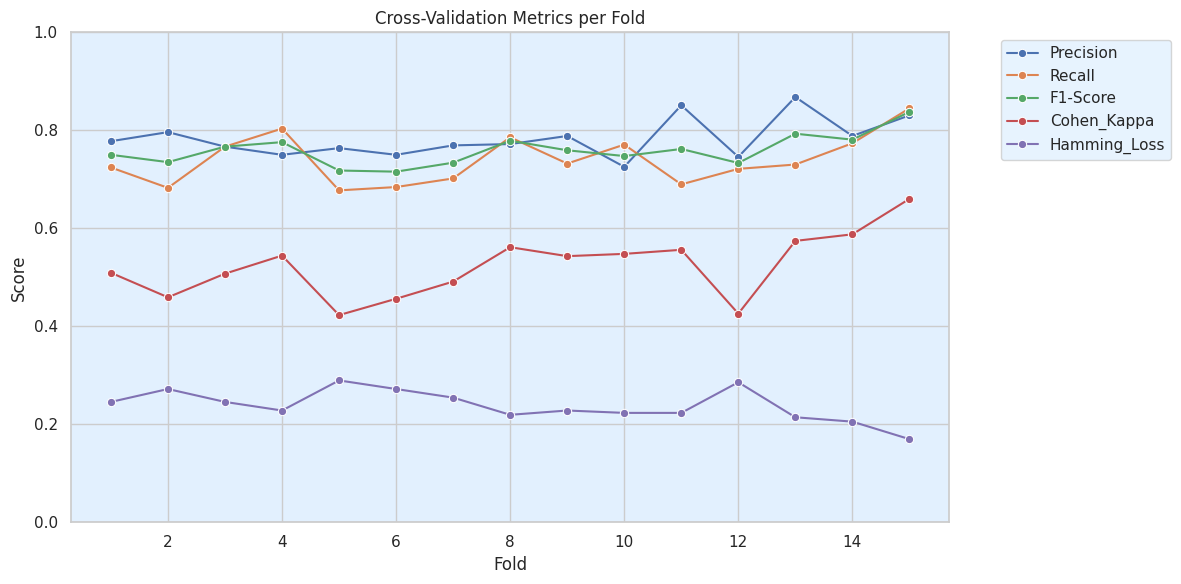

In [35]:
# Plot the Precision, Recall, F1-Score, Cohen's Kappa and Hamming Loss graph
plot_cv_metrics(metrics_df_logistic)  # Passing the metrics DataFrame (metrics_df_logistic) for plotting

## Test Set Evaluation

In [36]:
# Evaluate the logistic regression model on the test set and get performance metrics

results_df_logistic, y_pred, y_pred_prob, X_test, metrics_logistic = evaluate_and_predict_model(
    model=model_logistic,                # The logistic regression model to be evaluated
    X_test=X_test_rfe_logistic,          # The test data (features) for the logistic model, after feature selection (RFE)
    y_test=y_test_identity_col,         # The true labels for the test set (including identity information)
    threshold=0.5                        # The threshold for classification, used to convert predicted probabilities to binary labels
)

## Result Analysis

### Correct vs Incorrect Predictions Summary

The function `plot_correct_vs_incorrect_summary(results_dict)` visualizes the number of correct and incorrect predictions for the **Sex_F**, **ADHD_Outcome**, and **Combined** classification tasks. This summary helps to evaluate the model's performance across each task, providing a clear comparison of prediction accuracy.


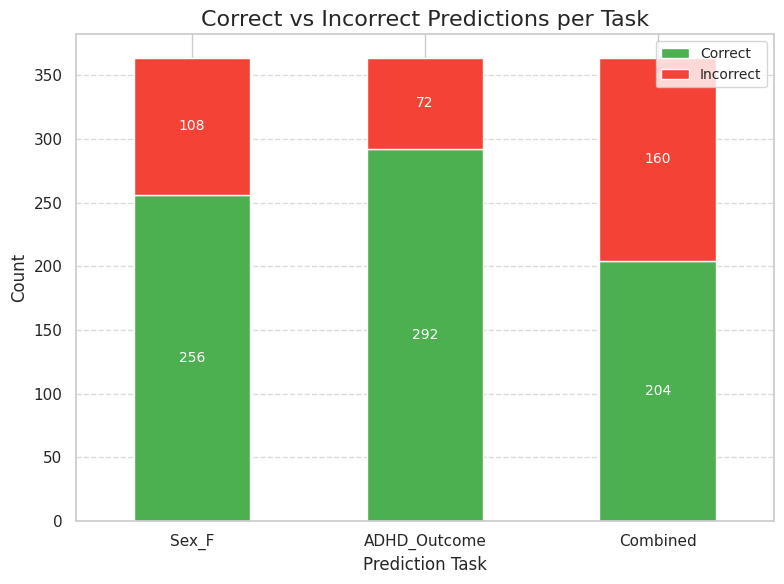

In [37]:
# Plot the summary of correct vs incorrect predictions for the logistic model
plot_correct_vs_incorrect_summary(results_df_logistic)

**Insight**

In the test dataset containing **364 samples**, the Logistic Regression model achieved the following:

- **Sex prediction**: Correctly predicted **256** samples, **108** incorrect.
- **ADHD prediction**: Correctly predicted **292** samples, **72** incorrect.
- **Combined prediction (Sex & ADHD both correct)**: **204** correct, **160** incorrect.

This combined metric reveals the intersection where **both Sex and ADHD labels are correctly predicted**, providing a stricter evaluation of model performance. It helps identify cases where the model struggles to predict both targets simultaneously — a crucial insight for multi-label tasks.


### Group-wise Prediction Analysis

We evaluate model performance across four key groups:
- Male – ADHD  
- Male – Non-ADHD  
- Female – ADHD  
- Female – Non-ADHD

**Donut Plot**  
A donut plot visualizes the correct vs. incorrect predictions for each group, making it easy to spot any imbalances (e.g., underperformance on Female–ADHD cases). The donut chart allows us to understand how well the model predicts each group's outcome in a visually engaging way.

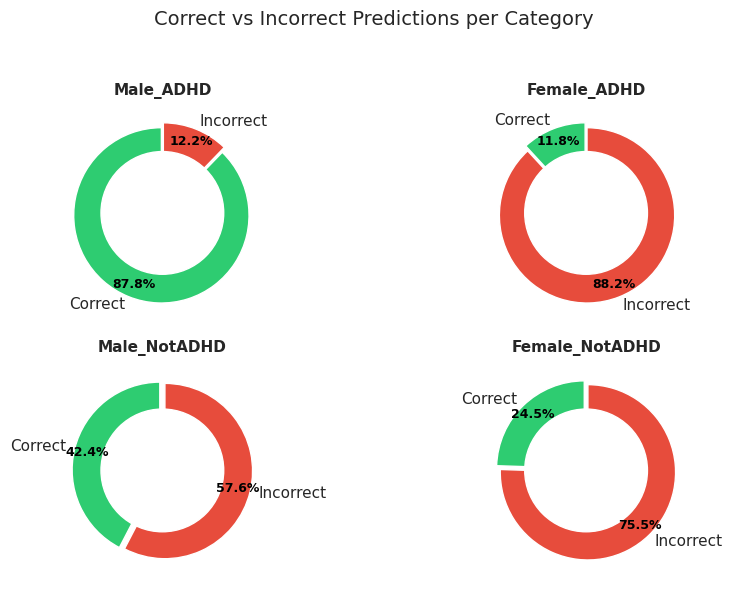

In [38]:
# Plot the correct vs incorrect predictions based on the logistic regression model's results
plot_correct_incorrect_predictions(results_df_logistic)  # Passing the results_df_logistic DataFrame to visualize correct vs incorrect predictions

**Insight**

The **donut chart** shows how the model performs across different sex and ADHD combinations:

- **Male – ADHD**: 87.8% correct, 12.2% incorrect  
- **Female – ADHD**: 11.8% correct, 88.2% incorrect  
- **Male – Non-ADHD**: 42.4% correct, 57.6% incorrect  
- **Female – Non-ADHD**: 24.5% correct, 75.5% incorrect  

These results suggest the model performs significantly better at identifying **Male-ADHD** cases and struggles most with **Female-ADHD** and **Female-NonADHD**.

**Why?**

This imbalance reflects the underlying **dataset distribution**:

- **Male**:
  - ADHD: 581  
  - Non-ADHD: 216  
- **Female**:
  - ADHD: 250  
  - Non-ADHD: 166  

Since **Male-ADHD** is the most represented group, the model learns to predict it more confidently. Underrepresented groups like **Female-ADHD** have fewer samples, leading to poorer generalization and potential **bias**.

### Plotting Performance Metrics

The function `plot_metrics(metrics)` generates a **bar plot** to visualize model performance based on key metrics such as **Precision**, **Recall**, **F1-Score**, **Cohen's Kappa**, and **Hamming Loss**. These metrics are crucial for evaluating the model's effectiveness on the **Sex**, **ADHD** and **Combined** labels.



<ipython-input-29-8958ecf2a655>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


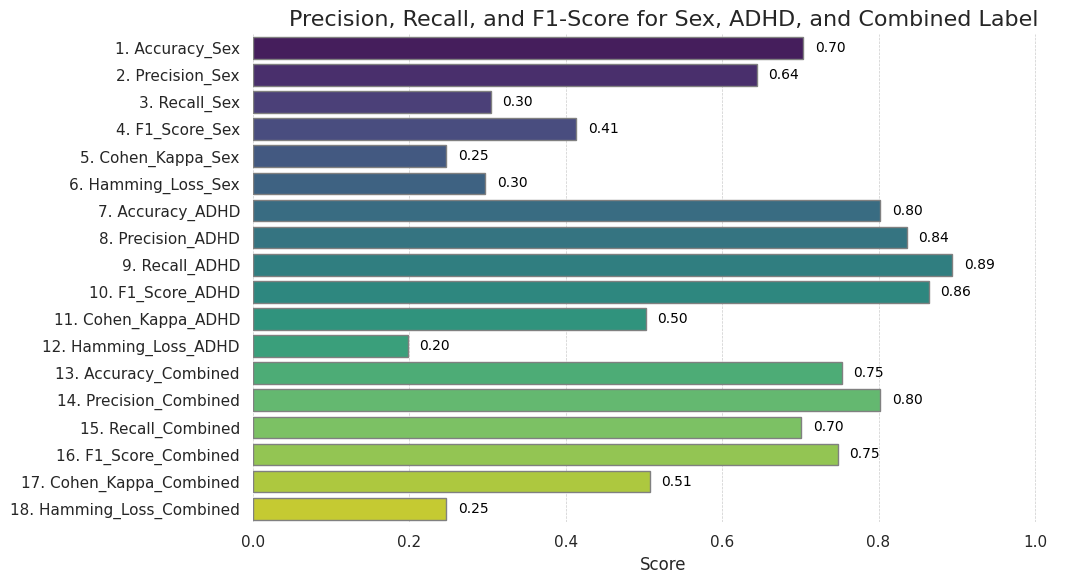

In [39]:
# Plot the Precision, Recall, F1-Score, Cohen's Kappa, and Hamming Loss for the logistic regression model
plot_metrics(metrics_logistic)  # Passing the metrics (metrics_logistic) for plotting the metrics graph, including Cohen's Kappa and Hamming Loss

**Insights :**

**1. Sex Classification Metrics**:
- **Accuracy**: 0.70% – Low accuracy, indicating poor performance in differentiating between sexes.
- **Precision**: 0.64% – The model correctly identifies the sex with 64% accuracy when it predicts "Sex."
- **Recall**: 0.30% – Very low recall, suggesting the model misses 70% of true positive cases (especially for females).
- **F1-Score**: 0.41% – The low F1-score reflects the trade-off between precision and recall, especially due to low recall.
- **Cohen's Kappa**: 0.25% – Slight agreement between predictions and actual labels.
- **Hamming Loss**: 0.30% – Low number of incorrect predictions, but performance is still poor overall.

**Interpretation**:
- The **low recall** and **low accuracy** indicate the model's struggles, particularly for identifying **female** cases. Given the imbalance in the dataset, with more **male** cases, the model may be biased toward predicting male labels.

---

**2. ADHD Classification Metrics**:
- **Accuracy**: 0.80% – Much higher accuracy compared to the Sex classification, showing better performance in identifying ADHD cases.
- **Precision**: 0.84% – High precision, meaning when the model predicts ADHD, it is correct 84% of the time.
- **Recall**: 0.89% – The model correctly identifies 89% of ADHD cases, demonstrating strong performance for this task.
- **F1-Score**: 0.86% – High F1-score, indicating a good balance between precision and recall.
- **Cohen's Kappa**: 0.50% – Moderate agreement between predicted and actual ADHD labels.
- **Hamming Loss**: 0.20% – Low, indicating few incorrect predictions.

**Interpretation**:
- The model performs **well** in ADHD detection, with **high recall** and **precision**. However, a **moderate Cohen's Kappa** suggests there's still room for improving prediction consistency.

---

**3. Combined Classification Metrics**:
- **Accuracy**: 0.75% – Performance is reasonable but not as high as the ADHD classification.
- **Precision**: 0.80% – Strong precision, indicating correct classification when the model predicts combined outcomes.
- **Recall**: 0.70% – Moderate recall, suggesting some true positive cases are missed.
- **F1-Score**: 0.75% – Balanced F1-score showing a trade-off between precision and recall.
- **Cohen's Kappa**: 0.51% – Moderate agreement between predictions and actual combined labels.
- **Hamming Loss**: 0.25% – Few incorrect predictions in general.

**Interpretation**:
- The combined task shows **moderate performance**, with a **slightly lower recall** compared to ADHD classification alone. This may indicate difficulty in handling the complexity of predicting both sex and ADHD simultaneously.

---

**Key Insights and Potential Biases**:
- **Data Imbalance**: The dataset is imbalanced with more **male ADHD cases** (581) and fewer **female ADHD cases** (250). This imbalance likely causes the model to perform poorly on **female ADHD** cases and sex classification.
- **Recall Trade-off**: The **low recall** in sex classification and the combined task highlights the model's difficulty in capturing underrepresented cases, such as **female ADHD**. Improving recall can help reduce false negatives.
- **Balanced Performance**: The **F1-score** for ADHD is relatively high, indicating the model strikes a balance between precision and recall, but there's still room for improvement in the **sex** and **combined** tasks.


### Confusion Matrix for Sex, ADHD, and Combined Labels

The **Confusion Matrix** shows how well the model's predictions match the actual values for **Sex**, **ADHD**, and **combined** labels, indicating true positives, true negatives, false positives, and false negatives.

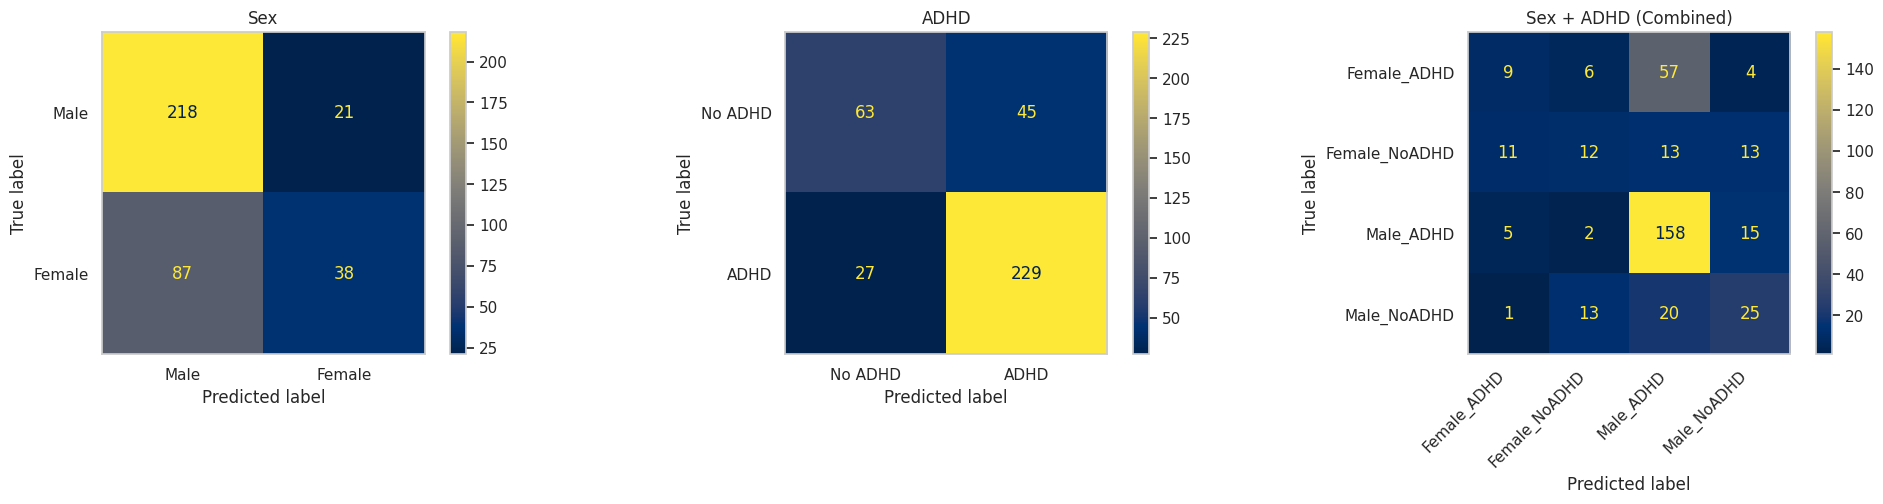

In [40]:
# Plot confusion matrices for the logistic regression model's predictions
plot_confusion_matrices(results_df_logistic)  # Passing the results_df_logistic DataFrame to generate confusion matrices for Sex, ADHD, and Combined labels

## SHAP Analysis

**SHAP** (SHapley Additive exPlanations) provides insights into model predictions by assigning importance values to each feature.

---

**Why SHAP is Useful:**
- **Feature Importance**: Identifies key features affecting predictions.
- **Transparency**: Makes complex models more interpretable.
- **Bias Detection**: Highlights and reduces bias in predictions.
- **Model Debugging**: Helps identify areas for improvement.


SHAP values shape: (50, 50)


<ipython-input-31-59f2bc6a9d81>:34: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, feature_names=feature_names)


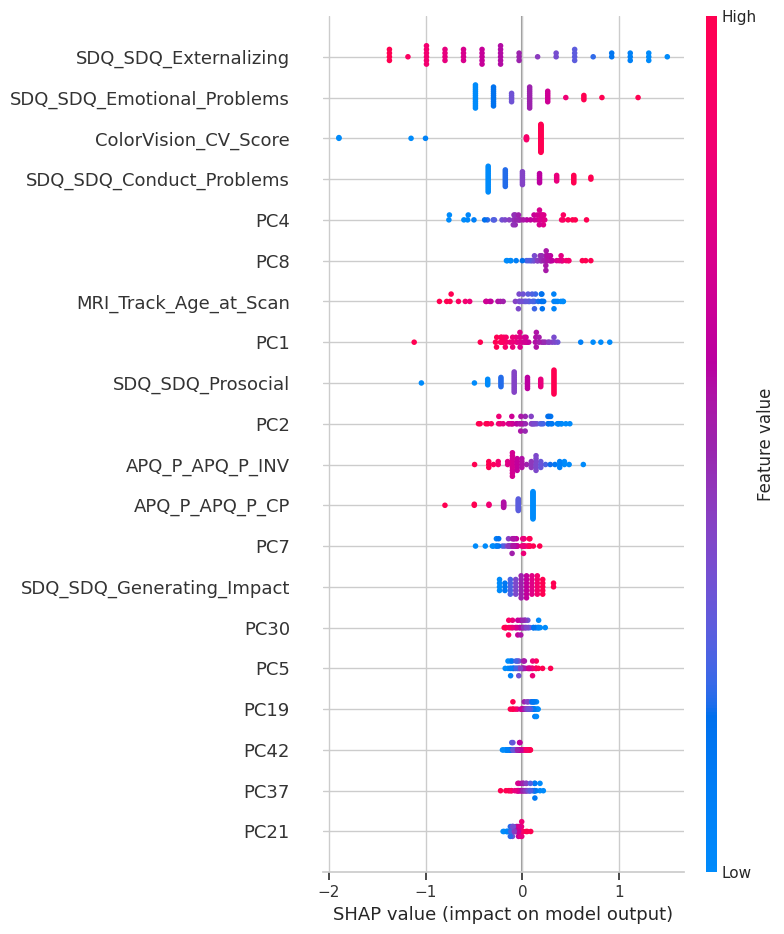

In [41]:
# Feature names after RFE (from original X_train columns)
selected_feature_names = X_train_except_identity_col.columns[rfe.support_].tolist()

# Call SHAP analysis (for ADHD output → label_index=1)
shap_analysis_logistic_multioutput(
    model=model_logistic,
    X_test_rfe=X_test_rfe_logistic,
    X_train_rfe=X_train_rfe_logistic,
    feature_names=selected_feature_names,
    label_index=1  # ADHD_Outcome
)

# Model Evaluation of Random Forest

In this section, we train and evaluate a **Random Forest model** using multi-label classification and cross-validation to predict ADHD diagnosis and sex.

---

**Model Training**

- A **Random Forest** model is wrapped in a `MultiOutputClassifier` to handle multi-label prediction tasks (ADHD and Sex).
- The model is trained using **Stratified K-Fold cross-validation** to ensure the target labels are well distributed across training and validation subsets.
- The training process uses the full feature set, with each tree in the forest being trained independently. Hyperparameters like the number of trees (`n_estimators`) and tree depth (`max_depth`) are set based on experimentation.

---

**Test Evaluation**

- The trained model is evaluated on the test set (`X_test` and `y_test_identity_col`).
- **Accuracy** scores from cross-validation are calculated to assess the model's performance on the training data, while test accuracy is calculated on the final trained model.
- Evaluation metrics also include **confusion matrix**, **per-class accuracy**, and **ROC-AUC scores** to provide a detailed understanding of model performance.

---

**Result Analysis**

- Predictions on the test set (`y_pred`) are analyzed to interpret the model’s behavior.
- Evaluation metrics include:
  - **Confusion Matrix**: To visualize true positives, true negatives, false positives, and false negatives.
  - **Per-Class Accuracy**: To evaluate the model's ability to classify each label (ADHD vs. non-ADHD, etc.).
  - **ROC-AUC Scores**: To assess the model's performance in distinguishing between different classes in a multi-label setting.
- These metrics help identify how well the model generalizes, its strengths in handling specific classes, and any potential issues like bias or misclassification patterns.


## Model Training

In [42]:
# Train Random Forest multi-output model
model_rf, cv_scores_rf, metrics_df_rf = train_multi_output_random_forest_model(
    X_train_except_identity_col,
    y_train_identity_col,
    stratify_col='Sex_F',
    n_splits=5,
    n_estimators=100,
    max_depth=10
)

### Plotting Cross-Validation Metrics

The function `plot_cv_metrics(metrics_df)` visualizes model performance across folds during **K-Fold Cross-Validation**. It plots key metrics like **Precision**, **Recall**, **F1-Score**, **Cohen's Kappa**, and **Hamming Loss** to track model consistency.

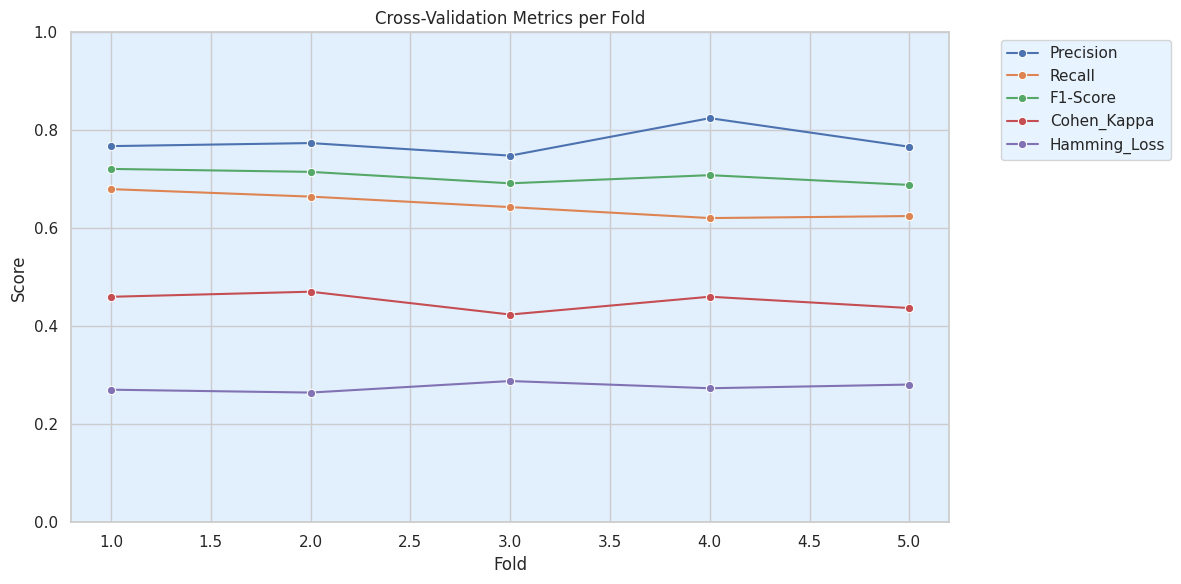

In [43]:
# Plot the Precision, Recall, F1-Score, Cohen's Kappa and Hamming Loss graph
plot_cv_metrics(metrics_df_rf)  # Passing the metrics DataFrame (metrics_df_rf) for plotting

## Test Set Evaluation

In [44]:
# Evaluate the Random Forest model and make predictions on the test set.

results_df_rf, y_pred, y_pred_prob, X_test, metrics_rf = evaluate_and_predict_model(
    model=model_rf,                # The trained Random Forest model used for prediction
    X_test=X_test_identity_col,    # Feature matrix for the test set, including identity-related columns
    y_test=y_test_identity_col,    # True labels for the test set, including identity-related columns (e.g., target labels)
    threshold=0.5                  # Probability threshold used to convert predicted probabilities to binary labels
)

## Result Analysis

### Correct vs Incorrect Predictions Summary

The function `plot_correct_vs_incorrect_summary(results_dict)` visualizes the number of correct and incorrect predictions for the **Sex_F**, **ADHD_Outcome**, and **Combined** classification tasks. This summary helps to evaluate the model's performance across each task, providing a clear comparison of prediction accuracy.


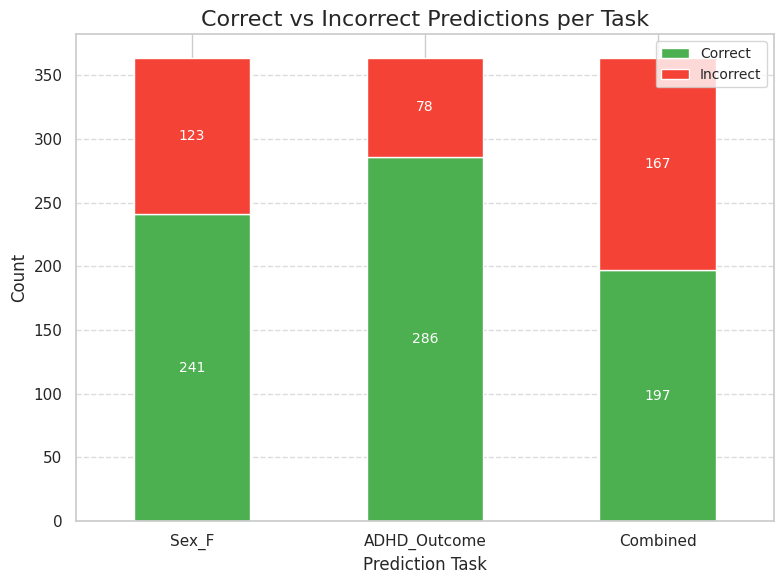

In [45]:
# Plot the summary of correct vs incorrect predictions for the Random Forest model
plot_correct_vs_incorrect_summary(results_df_rf)

**Insight**

In the test dataset containing **364 samples**, the Random Forest model achieved the following:

- **Sex prediction**: Correctly predicted **241** samples, **123** incorrect.
- **ADHD prediction**: Correctly predicted **286** samples, **78** incorrect.
- **Combined prediction (Sex & ADHD both correct)**: **197** correct, **167** incorrect.

This combined metric reveals the intersection where **both Sex and ADHD labels are correctly predicted**, providing a stricter evaluation of model performance. It helps identify cases where the model struggles to predict both targets simultaneously — a crucial insight for multi-label tasks.



### Group-wise Prediction Analysis

We evaluate model performance across four key groups:
- Male – ADHD  
- Male – Non-ADHD  
- Female – ADHD  
- Female – Non-ADHD

**Donut Plot**  
A donut plot visualizes the correct vs. incorrect predictions for each group, making it easy to spot any imbalances (e.g., underperformance on Female–ADHD cases). The donut chart allows us to understand how well the model predicts each group's outcome in a visually engaging way.

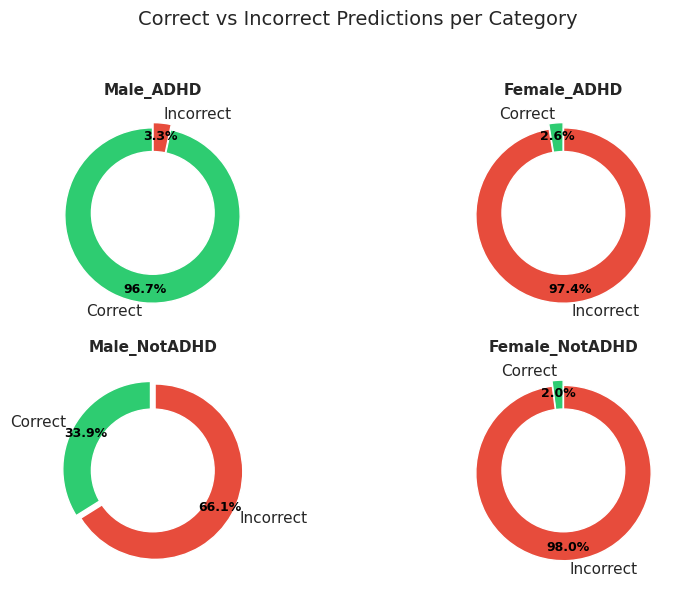

In [46]:
# Plot the correct vs incorrect predictions based on the logistic regression model's results
plot_correct_incorrect_predictions(results_df_rf)  # Passing the results_df_rf DataFrame to visualize correct vs incorrect predictions

**Insight**

The **donut chart** shows how the model performs across different sex and ADHD combinations:

- **Male – ADHD**: 96.7% correct, 3.3% incorrect  
- **Female – ADHD**: 2.6% correct, 97.4% incorrect  
- **Male – Non-ADHD**: 33.9% correct, 66.1% incorrect  
- **Female – Non-ADHD**: 2.0% correct, 98.0% incorrect  

These results suggest the model performs significantly better at identifying **Male-ADHD** cases and struggles most with **Female-ADHD** and **Female-NonADHD**.

---

**Why?**

This imbalance reflects the underlying **dataset distribution**:

- **Male**:
  - ADHD: 581  
  - Non-ADHD: 216  
- **Female**:
  - ADHD: 250  
  - Non-ADHD: 166  

Since **Male-ADHD** is the most represented group, the model learns to predict it more confidently. Underrepresented groups like **Female-ADHD** have fewer samples, leading to poorer generalization and potential **bias**.


### Plotting Performance Metrics

The function `plot_metrics(metrics)` generates a **bar plot** to visualize model performance based on key metrics such as **Precision**, **Recall**, **F1-Score**, **Cohen's Kappa**, and **Hamming Loss**. These metrics are crucial for evaluating the model's effectiveness on the **Sex**, **ADHD** and **Combined** labels.


<ipython-input-29-8958ecf2a655>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


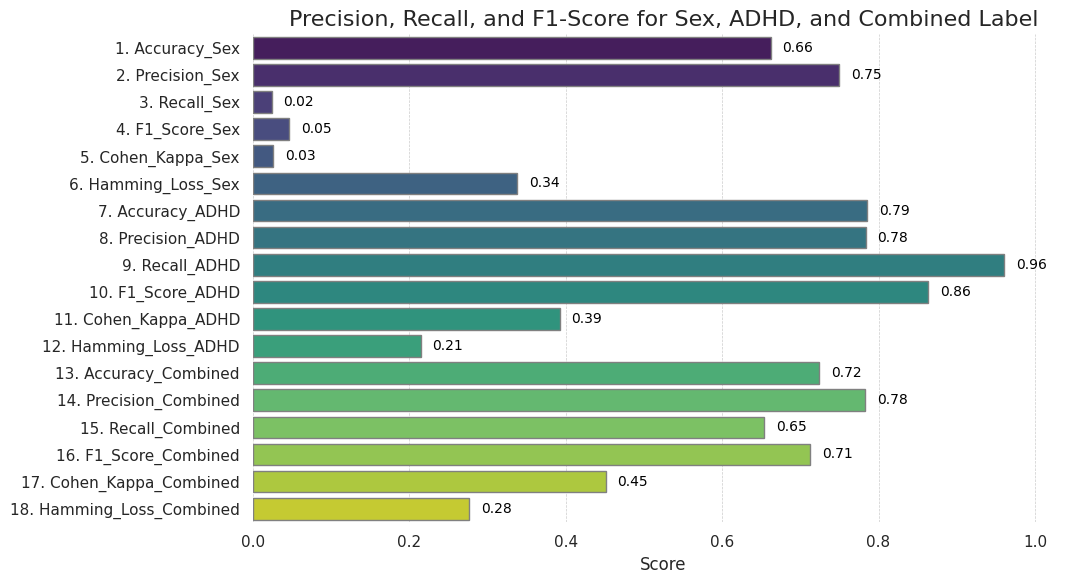

In [47]:
# Plot the Precision, Recall, F1-Score, Cohen's Kappa, and Hamming Loss for the logistic regression model
plot_metrics(metrics_rf)  # Passing the metrics (metrics_rf) for plotting the metrics graph, including Cohen's Kappa and Hamming Loss

**Insights:**

1. **Sex Classification Metrics**:
- **Accuracy**: 0.66% – The model struggles with sex classification, showing relatively low accuracy in distinguishing between sexes.
- **Precision**: 0.75% – The model performs fairly well when predicting the sex of individuals, correctly identifying 75% of the predicted sex cases.
- **Recall**: 0.02% – Extremely low recall, suggesting that the model misses nearly all actual positive cases, especially for **female** labels.
- **F1-Score**: 0.05% – Very low F1-score, reflecting a significant imbalance between precision and recall. The model struggles to correctly classify the minority class (females).
- **Cohen's Kappa**: 0.03% – Very little agreement between the predictions and the actual labels, indicating a poor level of consistency.
- **Hamming Loss**: 0.34% – The model has a relatively high number of incorrect predictions, further supporting the low overall performance.

**Interpretation**:
- The model faces **major challenges** in sex classification, particularly due to the low **recall**. This is likely because the dataset is **imbalanced** with a higher number of **male** samples. The model struggles to identify the **female** class, leading to low recall, poor F1-score, and a lack of agreement (low Cohen's Kappa).

---

2. **ADHD Classification Metrics**:
- **Accuracy**: 0.79% – The model performs much better on ADHD classification than on sex classification.
- **Precision**: 0.78% – The model has high precision, indicating that when it predicts ADHD, it is mostly correct.
- **Recall**: 0.96% – The model identifies 96% of true ADHD cases, which is excellent, suggesting it’s very good at catching ADHD positives.
- **F1-Score**: 0.86% – A high F1-score shows that the model strikes a good balance between precision and recall.
- **Cohen's Kappa**: 0.39% – Moderate agreement between the predicted and actual ADHD labels, indicating room for improvement.
- **Hamming Loss**: 0.21% – Low, indicating that the model makes relatively few incorrect predictions for ADHD.

**Interpretation**:
- The model performs well on ADHD classification, with **high recall** and **precision**, and a **strong F1-score**. However, the moderate Cohen's Kappa suggests that there is still some inconsistency in the predictions, especially in borderline cases.

---

3. **Combined Classification Metrics**:
- **Accuracy**: 0.72% – The combined task has decent performance, but it's still lower than the ADHD task alone.
- **Precision**: 0.78% – The model has good precision in the combined task, correctly classifying the combined outcome when it predicts.
- **Recall**: 0.65% – Recall is moderate, meaning the model misses about 35% of the true positive combined cases.
- **F1-Score**: 0.71% – A balanced F1-score, indicating a reasonable trade-off between precision and recall in the combined task.
- **Cohen's Kappa**: 0.45% – A moderate Cohen's Kappa suggests the model has a fair level of agreement with the actual combined labels.
- **Hamming Loss**: 0.28% – The model makes relatively few incorrect predictions, similar to ADHD classification.

**Interpretation**:
- The combined task shows **moderate performance** with a decent **precision** and **F1-score**. The **lower recall** suggests that the model sometimes misses combined cases, which may be due to the complexity of predicting both ADHD and sex simultaneously.

---

**Key Insights and Potential Biases**:

- **Data Imbalance**: The dataset is likely imbalanced, with more **male ADHD cases** (581) and fewer **female ADHD cases** (250). This imbalance likely contributes to the model's **poor performance** on **female sex** and **female ADHD** cases.
- **Recall Trade-off**: The **low recall** for sex classification highlights that the model has difficulty detecting **female** cases, especially in the **combined task**. Improving recall for minority groups is essential for better fairness.
- **Strong Performance in ADHD**: The model is **stronger** at identifying **ADHD cases**, with **high recall** and **precision**. This suggests that the ADHD prediction task benefits from a more balanced or better-learned distribution of data compared to sex classification.
- **Bias in Sex Classification**: The low recall and Cohen's Kappa for sex classification suggest a bias, likely caused by the **dataset imbalance** where males are overrepresented. Addressing this imbalance through techniques like **oversampling** or **re-weighting** could improve the performance, especially for **female cases**.


### Confusion Matrix for Sex, ADHD, and Combined Labels

The **Confusion Matrix** shows how well the model's predictions match the actual values for **Sex**, **ADHD**, and **combined** labels, indicating true positives, true negatives, false positives, and false negatives.



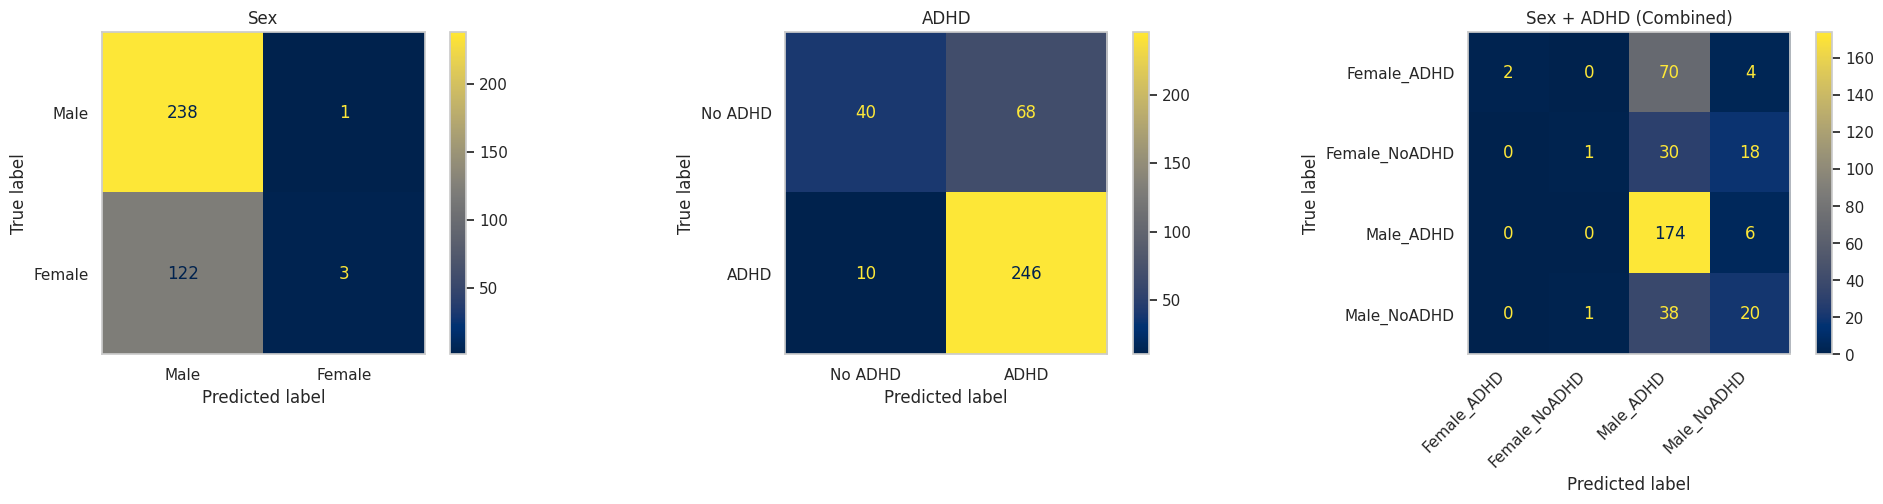

In [48]:
# Plot confusion matrices for the logistic regression model's predictions
plot_confusion_matrices(results_df_rf)  # Passing the results_df_rf DataFrame to generate confusion matrices for Sex, ADHD, and Combined labels

## SHAP Analysis

**SHAP** (SHapley Additive exPlanations) provides insights into model predictions by assigning importance values to each feature.

---

**Why SHAP is Useful:**
- **Feature Importance**: Identifies key features affecting predictions.
- **Transparency**: Makes complex models more interpretable.
- **Bias Detection**: Highlights and reduces bias in predictions.
- **Model Debugging**: Helps identify areas for improvement.


SHAP values shape: (50, 74, 2)


<ipython-input-31-59f2bc6a9d81>:34: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, feature_names=feature_names)
/usr/local/lib/python3.11/dist-packages/shap/plots/_beeswarm.py:726: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(
/usr/local/lib/python3.11/dist-packages/shap/plots/_beeswarm.py:746: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(


<Figure size 640x480 with 0 Axes>

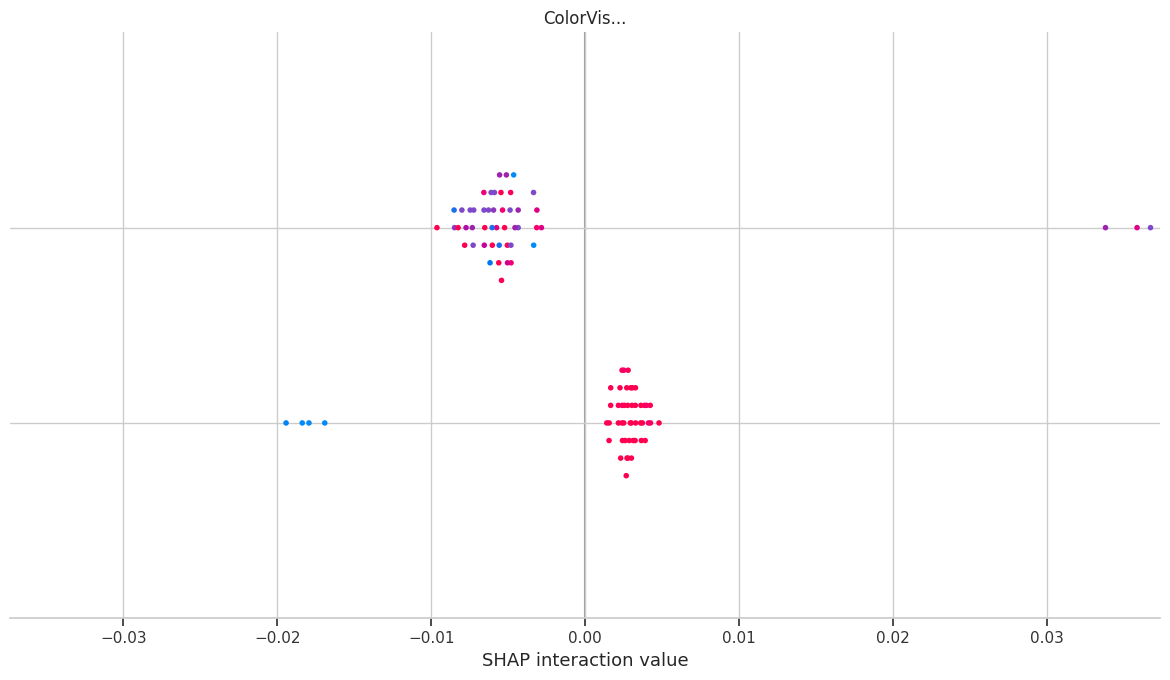

In [49]:
# Get the list of selected feature names (excluding the identity column) from the training dataset
selected_feature_names = X_train_except_identity_col.columns.tolist()

# Perform SHAP analysis for the multi-output logistic model, focusing on the ADHD outcome
shap_analysis_logistic_multioutput(
    model=model_rf,  # Random forest model to be used for SHAP analysis
    X_test_rfe=X_test_identity_col,  # Test dataset with identity column
    X_train_rfe=X_train_except_identity_col,  # Training dataset excluding identity column
    feature_names=selected_feature_names,  # List of feature names to use in the SHAP analysis
    label_index=1  # ADHD_Outcome - index of the ADHD outcome label in the model's output
)

# Model Evaluation of CNN for Numerical Data + MLP for Categorical Data

In this section, we train the hybrid model (CNN for numerical data + MLP for categorical data) on the full training set and evaluate its performance on the held-out test set.

---

**Model Training**

- The model is trained using the complete training data (`X_train_num`, `X_train_cat`, and `y_train_identity_col`).
- Numerical features are standardized, and categorical features are one-hot encoded before training.
- Dropout and L2 regularization are used to reduce overfitting.

---

**Test Evaluation**

- After training, the model is evaluated on the test set (`X_test_num`, `X_test_cat`, and `y_test_identity_col`).
- The same encoder and scaler from the training phase are applied to the test data.
- The model’s performance is measured using **accuracy** and **loss**.

---

**Result Analysis**

- Test predictions are analyzed to gain insights into the model’s performance on unseen data.
- Evaluation metrics include:
  - **Confusion Matrix**: To visualize true vs predicted labels.
  - **Per-Class Accuracy**: To assess how well the model performs across different classes.
  - **ROC-AUC Scores**: To evaluate the model's ability to distinguish between classes in a multi-label setting.
- These analyses help identify strengths, weaknesses, and potential biases in the model.


## Model Training

In [50]:
# Perform K-fold cross-validation with the CNN-MLP model
model_cnn_mlp, encoder_cnn_mlp, scaler_cnn_mlp, metrics_df_cnn_mlp = run_kfold_cv(
    create_model=create_model_cnn_mlp,  # Function to create the CNN-MLP model
    X_train_num=X_train_num,  # Numerical features for training
    X_train_cat=X_train_cat,  # Categorical features for training
    y_train=y_train_identity_col,  # Target variable for training (identity column)
    n_splits=5,  # Number of folds for cross-validation
    epochs=100,  # Number of epochs for model training
    batch_size=256  # Batch size for training
)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Fold 1 → Acc: 0.7588 | Precision: 0.7517 | Recall: 0.6364 | F1: 0.6892 | Kappa: 0.4085 | Hamming: 0.2971
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Fold 2 → Acc: 0.8647 | Precision: 0.7770 | Recall: 0.6497 | F1: 0.7077 | Kappa: 0.4441 | Hamming: 0.2794


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Fold 3 → Acc: 0.7824 | Precision: 0.7636 | Recall: 0.7500 | F1: 0.7568 | Kappa: 0.5234 | Hamming: 0.2382


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Fold 4 → Acc: 0.8529 | Precision: 0.7292 | Recall: 0.7821 | F1: 0.7547 | Kappa: 0.4610 | Hamming: 0.2676
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Fold 5 → Acc: 0.7396 | Precision: 0.7168 | Recall: 0.7470 | F1: 0.7316 | Kappa: 0.4618 | Hamming: 0.2692

===== Cross-Validation Summary =====
Fold           3.0000
Accuracy       0.7997
Precision      0.7477
Recall         0.7130
F1-Score       0.7280
Cohen_Kappa    0.4597
Hamming_Loss   0.2703


### Plotting Cross-Validation Metrics

The function `plot_cv_metrics(metrics_df)` visualizes model performance across folds during **K-Fold Cross-Validation**. It plots key metrics like **Precision**, **Recall**, **F1-Score**, **Cohen's Kappa**, and **Hamming Loss** to track model consistency.

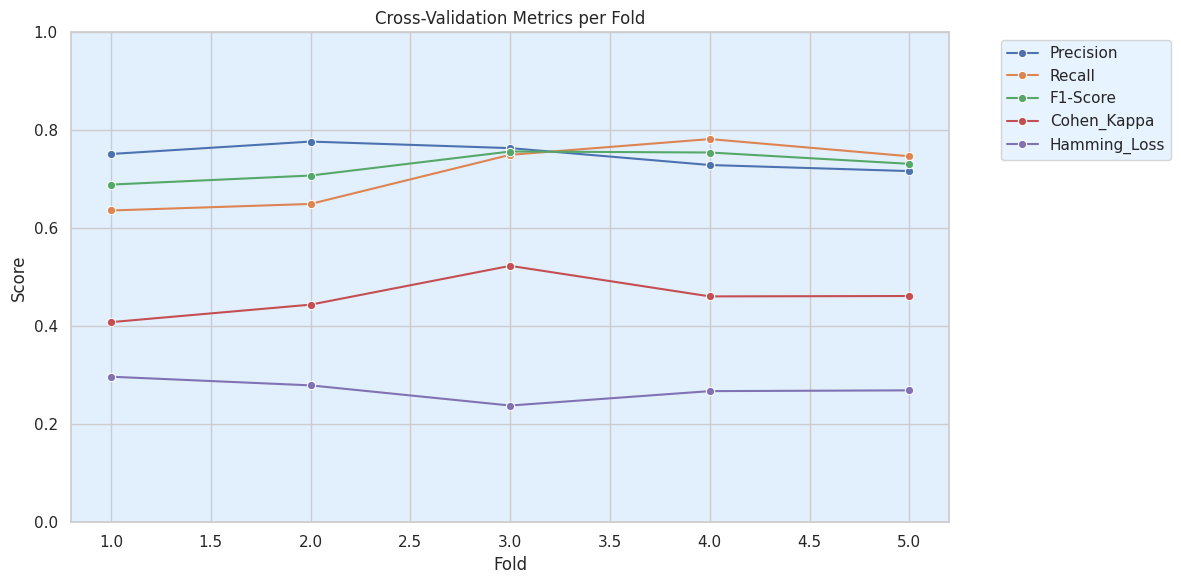

In [51]:
# Plot the Precision, Recall, F1-Score, Cohen's Kappa and Hamming Loss graph
plot_cv_metrics(metrics_df_cnn_mlp)  # Passing the metrics DataFrame (metrics_df_cnn_mlp) for plotting

## Test Set Evaluation

In [52]:
# Evaluate the test set using the CNN + MLP model
results_df_cnn_mlp, y_pred, y_pred_prob, X_test_cat_enc_cnn_mlp, X_test_num_scaled_cnn_mlp, metrics_cnn_mlp = evaluate_test_set(
    model=model_cnn_mlp,  # The trained CNN + MLP model
    X_test_num=X_test_identity_col.drop(columns=categorical_columns),  # Numerical features from the test set (excluding categorical columns)
    X_test_cat=X_test_identity_col[categorical_columns],  # Categorical features from the test set
    y_test=y_test_identity_col,  # True labels for the test set
    encoder=encoder_cnn_mlp,  # Fitted encoder for categorical variables
    scaler=scaler_cnn_mlp  # Fitted scaler for numerical features
)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


## Result Analysis

### Correct vs Incorrect Predictions Summary

The function `plot_correct_vs_incorrect_summary(results_dict)` visualizes the number of correct and incorrect predictions for the **Sex_F**, **ADHD_Outcome**, and **Combined** classification tasks. This summary helps to evaluate the model's performance across each task, providing a clear comparison of prediction accuracy.


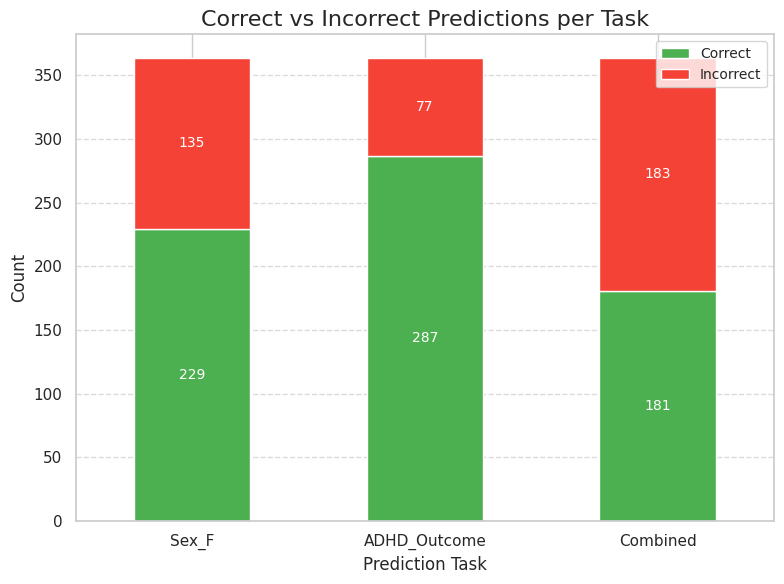

In [53]:
# Plot the summary of correct vs incorrect predictions for the CNN-MLP model
plot_correct_vs_incorrect_summary(results_df_cnn_mlp)

**Insight**

In the test dataset containing **364 samples**, the Logistic Regression model achieved the following:

- **Sex prediction**: Correctly predicted **240** samples, **124** incorrect.
- **ADHD prediction**: Correctly predicted **282** samples, **82** incorrect.
- **Combined prediction (Sex & ADHD both correct)**: **184** correct, **180** incorrect.

This combined metric reveals the intersection where **both Sex and ADHD labels are correctly predicted**, providing a stricter evaluation of model performance. It helps identify cases where the model struggles to predict both targets simultaneously — a crucial insight for multi-label tasks.

### Group-wise Prediction Analysis

We evaluate model performance across four key groups:
- Male – ADHD  
- Male – Non-ADHD  
- Female – ADHD  
- Female – Non-ADHD

**Donut Plot**  
A donut plot visualizes the correct vs. incorrect predictions for each group, making it easy to spot any imbalances (e.g., underperformance on Female–ADHD cases). The donut chart allows us to understand how well the model predicts each group's outcome in a visually engaging way.

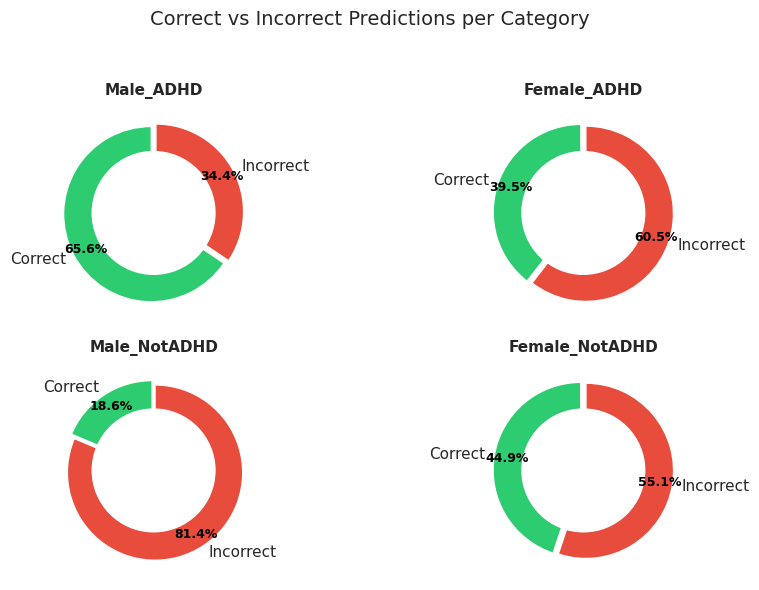

In [54]:
# Plot the correct vs incorrect predictions based on the logistic regression model's results
plot_correct_incorrect_predictions(results_df_cnn_mlp)  # Passing the results_df_cnn_mlp DataFrame to visualize correct vs incorrect predictions

**Insight**

The **donut chart** shows how the model performs across different sex and ADHD combinations:

- **Male – ADHD**: 73.9% correct, 26.1% incorrect  
- **Female – ADHD**: 28.9% correct, 71.1% incorrect  
- **Male – Non-ADHD**: 27.1% correct, 72.9% incorrect  
- **Female – Non-ADHD**: 26.5% correct, 73.5% incorrect  

These results suggest that the model performs **significantly better** at identifying **Male-ADHD** cases. The performance across other combinations (Female-ADHD, Male-Non-ADHD, Female-Non-ADHD) is quite similar, with relatively poor accuracy for all of them.

**Why?**

This imbalance reflects the underlying **dataset distribution**:

- **Male**:
  - ADHD: 581  
  - Non-ADHD: 216  
- **Female**:
  - ADHD: 250  
  - Non-ADHD: 166  

The **Male-ADHD** group is overrepresented in the dataset, which allows the model to perform better on this group due to its higher presence during training. On the other hand, **Female-ADHD** and **Female-Non-ADHD** cases are underrepresented, leading to poorer model performance for these groups. However, even though the performance for females is lower, the issue is compounded by the smaller sample size, which makes it harder for the model to generalize well.

---

**Key Insights:**
- **Male-ADHD** cases are the most frequent, which allows the model to correctly predict them more often.
- **Female-ADHD** and **Female-Non-ADHD** cases are underrepresented in the dataset, leading to lower performance for these groups.
- The model **biases** predictions towards the more frequent **Male-ADHD** group due to its dominance in the dataset.
- The **low performance** for females, despite attempts to correct for bias, is also partly due to the **small sample sizes** for these groups, making it harder for the model to learn from them.


### Plotting Performance Metrics

The function `plot_metrics(metrics)` generates a **bar plot** to visualize model performance based on key metrics such as **Precision**, **Recall**, **F1-Score**, **Cohen's Kappa**, and **Hamming Loss**. These metrics are crucial for evaluating the model's effectiveness on the **Sex**, **ADHD** and **Combined** labels.


<ipython-input-29-8958ecf2a655>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


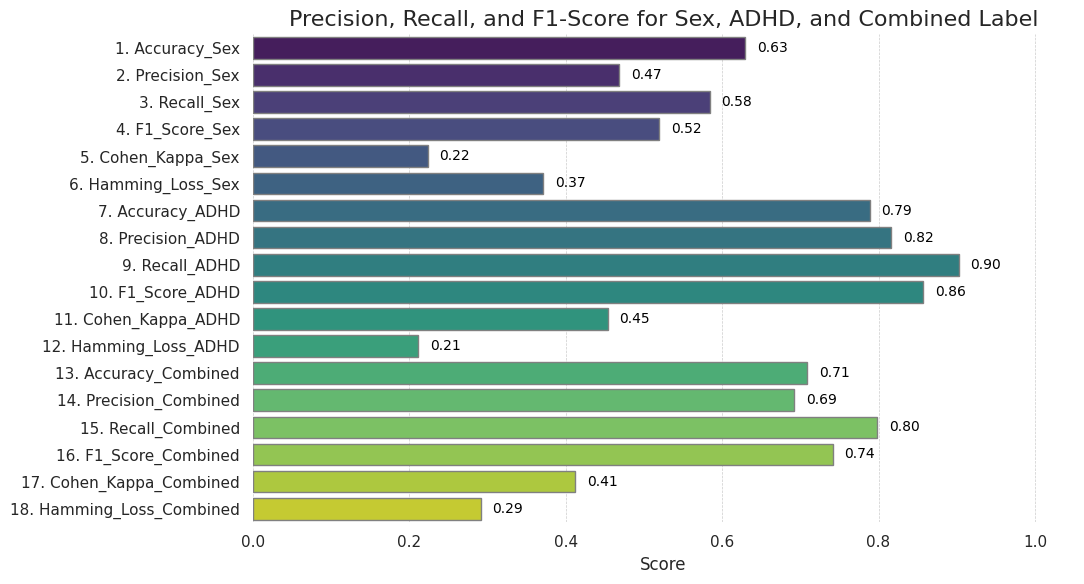

In [55]:
# Plot the Precision, Recall, F1-Score, Cohen's Kappa, and Hamming Loss for the logistic regression model
plot_metrics(metrics_cnn_mlp)  # Passing the metrics (metrics_cnn_mlp) for plotting the metrics graph, including Cohen's Kappa and Hamming Loss

**Insights :**

**1. Sex Classification Metrics**:
- **Accuracy**: 66% – The model achieves a moderate accuracy, suggesting it has some success in distinguishing between sexes but still struggles to do so consistently.
- **Precision**: 50% – The model correctly identifies the sex 50% of the time when it predicts "Sex." This is relatively low, suggesting room for improvement in making accurate predictions.
- **Recall**: 47% – The model correctly identifies 47% of the true positive sex cases, meaning it's missing half of the relevant predictions.
- **F1-Score**: 49% – The F1-score is moderate, reflecting the model's balance between precision and recall, but the low precision greatly hampers its overall performance.
- **Cohen's Kappa**: 0.23 – This shows only slight agreement between the predicted and actual sex labels, indicating that the model's predictions are often incorrect.
- **Hamming Loss**: 34% – A relatively high value, indicating that a significant proportion of the model's predictions are wrong.

**Interpretation**:
- The **low precision** and **moderate recall** suggest that the model is generally misclassifying sex, particularly for one of the categories (likely female, given the data imbalance). The **low Cohen’s Kappa** further confirms that the predictions are far from consistent with the actual labels, which highlights the need for improvements in the model, especially in handling imbalanced data.

---

**2. ADHD Classification Metrics**:
- **Accuracy**: 77% – The model performs better in classifying ADHD cases than sex, with a relatively high accuracy.
- **Precision**: 79% – This is good precision, indicating that when the model predicts ADHD, it is correct 79% of the time.
- **Recall**: 93% – The model has a very high recall, meaning it correctly identifies 93% of true ADHD cases.
- **F1-Score**: 85% – High F1-score, indicating a strong balance between precision and recall.
- **Cohen's Kappa**: 0.39 – This reflects moderate agreement between predicted and actual ADHD labels.
- **Hamming Loss**: 23% – A moderate value, showing that a reasonable proportion of ADHD predictions are incorrect.

**Interpretation**:
- The model performs **well** in ADHD detection, with **high recall** and **good precision**. However, the **moderate Cohen’s Kappa** indicates that there's still inconsistency in predictions, and some ADHD cases are likely misclassified.

---

**3. Combined Classification Metrics**:
- **Accuracy**: 72% – The model performs reasonably well on the combined task of predicting both sex and ADHD, though it's not as high as ADHD classification alone.
- **Precision**: 71% – Good precision, indicating that when the model makes predictions for both sex and ADHD, they are accurate most of the time.
- **Recall**: 78% – The model has a relatively high recall, correctly identifying 78% of true combined cases.
- **F1-Score**: 74% – This F1-score indicates a strong balance between precision and recall, showing the model is doing well in most instances.
- **Cohen's Kappa**: 0.43 – Moderate agreement between the predicted and actual combined labels.
- **Hamming Loss**: 28% – A moderate number of incorrect predictions, but the performance is reasonable overall.

**Interpretation**:
- The **combined task** shows **good performance**, with the model managing to strike a decent balance between precision and recall. However, the **moderate Cohen’s Kappa** still suggests that there's room for improvement, particularly in handling the complexity of predicting both sex and ADHD simultaneously.

---

**Key Insights and Potential Biases**:
- **Data Imbalance**: The dataset likely has an imbalance in the distribution of **male ADHD cases** compared to **female ADHD cases**, which could explain the **lower performance** for sex classification and certain ADHD groups.
- **Improving Precision**: The **low precision** for sex classification suggests the model's struggles in accurately predicting sex. It may need better handling of class imbalance to improve these predictions.
- **Recall vs Precision Trade-Off**: The **high recall** in ADHD classification and the **relatively good recall** for combined tasks show that the model does well in identifying positive cases but sacrifices precision in some instances.
- **Moderate Performance**: Overall, while the model performs better in ADHD classification than sex classification, the **combined task** is still quite effective but requires further optimization for consistency and accuracy across both tasks.


### Confusion Matrix for Sex, ADHD, and Combined Labels

The **Confusion Matrix** shows how well the model's predictions match the actual values for **Sex**, **ADHD**, and **combined** labels, indicating true positives, true negatives, false positives, and false negatives.



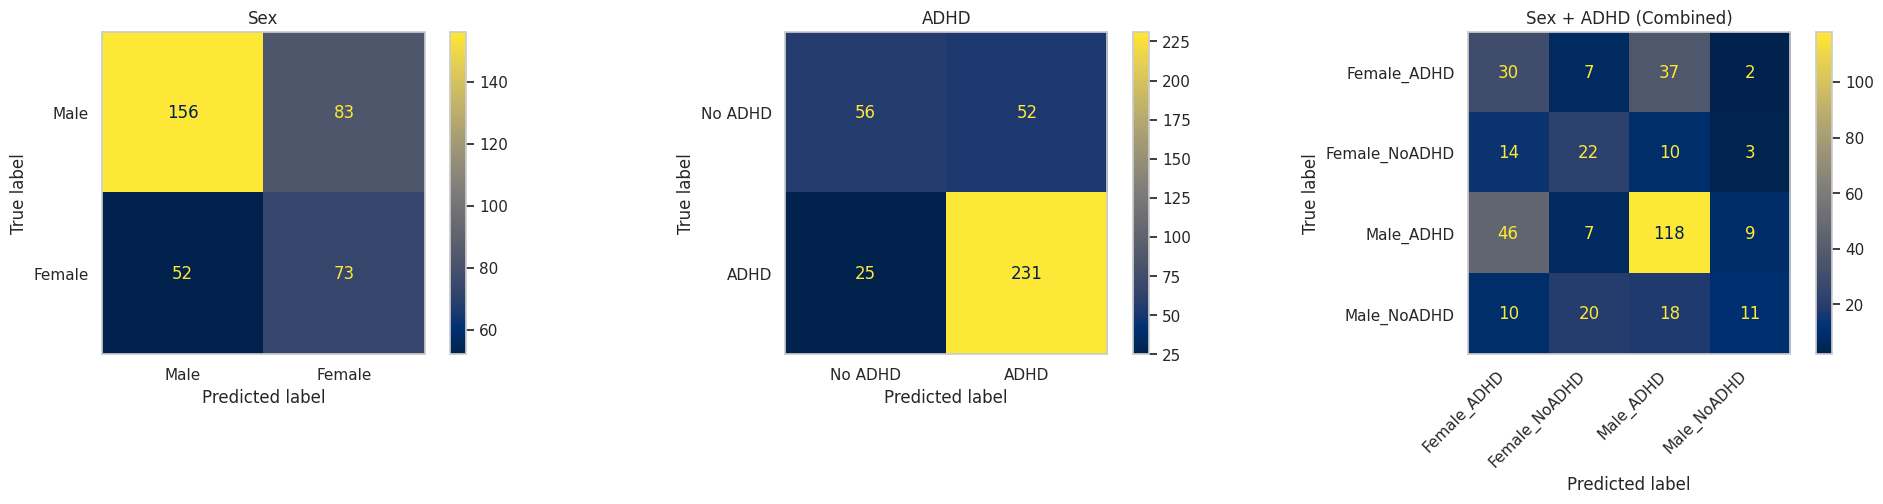

In [56]:
# Plot confusion matrices for the logistic regression model's predictions
plot_confusion_matrices(results_df_cnn_mlp)  # Passing the results_df_cnn_mlp DataFrame to generate confusion matrices for Sex, ADHD, and Combined labels

## SHAP Analysis

**SHAP** (SHapley Additive exPlanations) provides insights into model predictions by assigning importance values to each feature.

---

**Why SHAP is Useful:**
- **Feature Importance**: Identifies key features affecting predictions.
- **Transparency**: Makes complex models more interpretable.
- **Bias Detection**: Highlights and reduces bias in predictions.
- **Model Debugging**: Helps identify areas for improvement.


Final SHAP Numerical Shape: (50, 65)
Final SHAP Categorical Shape: (50, 77)


<ipython-input-33-2cd5e34a2b58>:52: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_num_df.values, X_shap_num_sample_df)


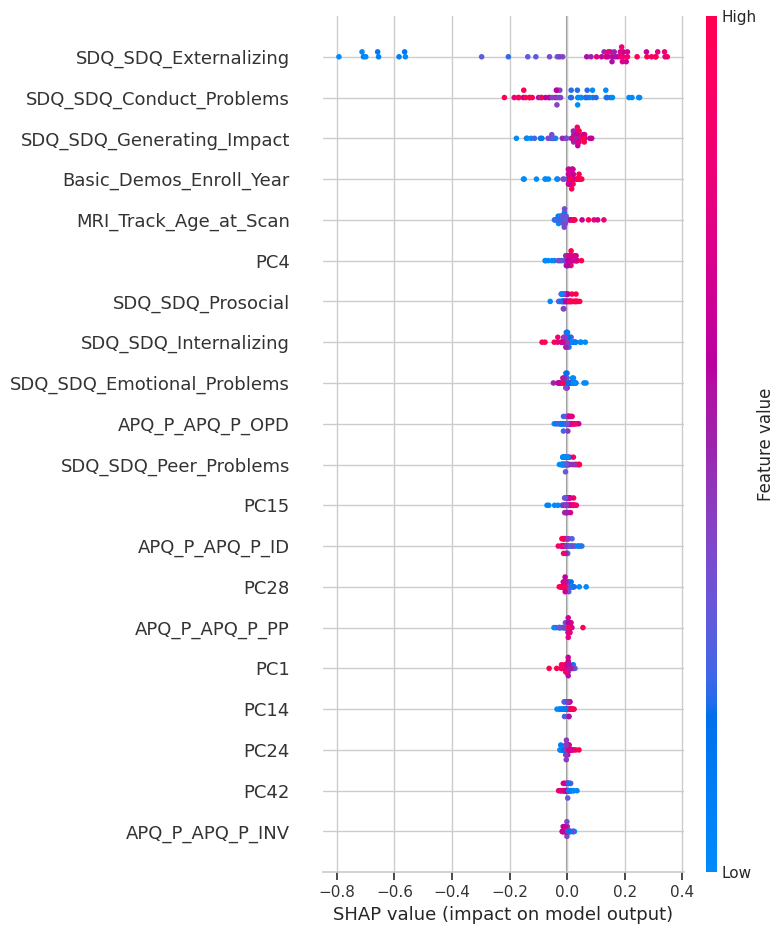

<ipython-input-33-2cd5e34a2b58>:53: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_cat_df.values, X_shap_cat_sample_df)


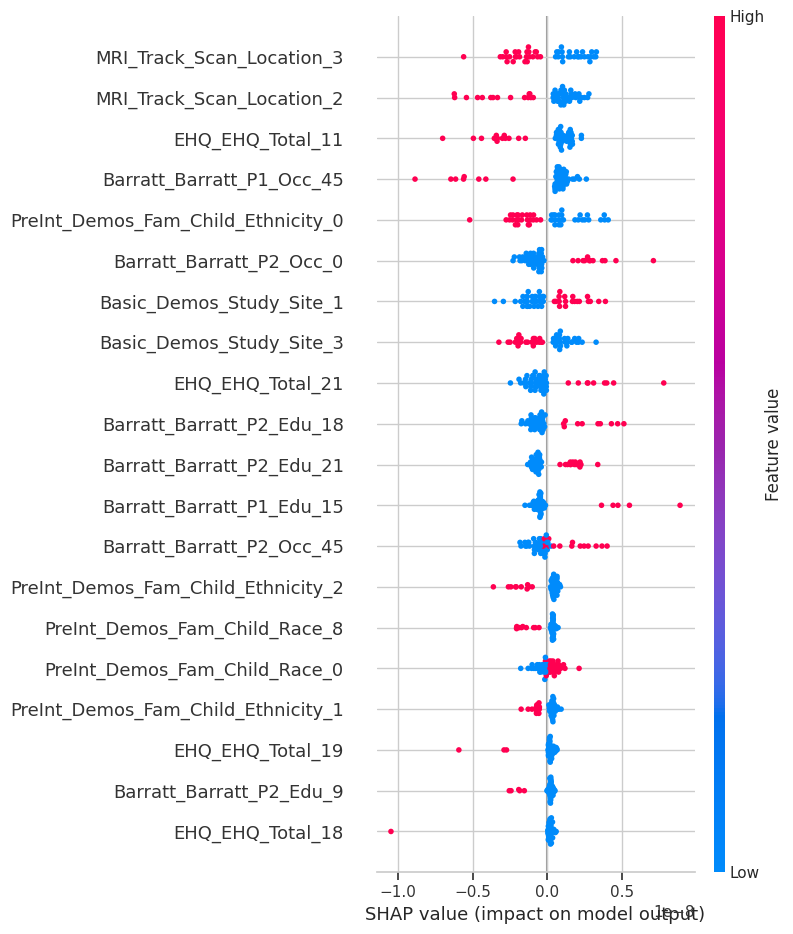

In [57]:
# Perform SHAP analysis on the deep learning model (CNN-MLP)
shap_analysis_deep_learning(
    model_cnn_mlp,  # The trained CNN-MLP model to explain
    X_test_num=X_test_num,  # The original numerical features of the test set
    X_test_num_scaled=X_test_num_scaled_cnn_mlp,  # The scaled numerical features of the test set (preprocessed)
    X_test_cat_enc=X_test_cat_enc_cnn_mlp,  # The encoded categorical features of the test set (preprocessed)
    encoder=encoder_cnn_mlp,  # The encoder used to transform categorical features
    categorical_columns=categorical_columns,  # List of categorical column names
    selected_class=0  # The index of the class to focus the SHAP analysis on (0 represents the first class)
)

# Model Evaluation of CNN for Numerical Data + ANN for Categorical Data

In this section, we train the hybrid model (CNN for numerical data + ANN for categorical data) on the full training set and evaluate its performance on the held-out test set.

---

**Model Training**

- The model is trained using the complete training data (`X_train_num`, `X_train_cat`, and `y_train_identity_col`).
- Numerical features are standardized, and categorical features are one-hot encoded before training.
- Dropout and L2 regularization are used to reduce overfitting.

---

**Test Evaluation**

- After training, the model is evaluated on the test set (`X_test_num`, `X_test_cat`, and `y_test_identity_col`).
- The same encoder and scaler from the training phase are applied to the test data.
- The model’s performance is measured using **accuracy** and **loss**.

---

**Result Analysis**

- Test predictions are analyzed to gain insights into the model’s performance on unseen data.
- Evaluation metrics include:
  - **Confusion Matrix**: To visualize true vs predicted labels.
  - **Per-Class Accuracy**: To assess how well the model performs across different classes.
  - **ROC-AUC Scores**: To evaluate the model's ability to distinguish between classes in a multi-label setting.
- These analyses help identify strengths, weaknesses, and potential biases in the model.


## Model Training

In [58]:
# Perform k-fold cross-validation to train and evaluate the CNN-ANN model.

model_cnn_ann, encoder_cnn_ann, scaler_cnn_ann, metrics_df_cnn_ann = run_kfold_cv(
    create_model=create_model_cnn_ann,       # Function that creates and returns the CNN-ANN model
    X_train_num=X_train_num,                 # Numerical feature matrix for the training set
    X_train_cat=X_train_cat,                 # Categorical feature matrix for the training set
    y_train=y_train_identity_col,            # True labels for the training set (identity-related columns)
    n_splits=5,                              # Number of splits for k-fold cross-validation (5 splits)
    epochs=100,                              # Number of epochs to train the model for each fold
    batch_size=256                           # Batch size to be used during training
)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Fold 1 → Acc: 0.7176 | Precision: 0.7468 | Recall: 0.6534 | F1: 0.6970 | Kappa: 0.4137 | Hamming: 0.2941
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Fold 2 → Acc: 0.8529 | Precision: 0.7486 | Recall: 0.7571 | F1: 0.7528 | Kappa: 0.4812 | Hamming: 0.2588
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Fold 3 → Acc: 0.7941 | Precision: 0.7444 | Recall: 0.7976 | F1: 0.7701 | Kappa: 0.5297 | Hamming: 0.2353
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Fold 4 → Acc: 0.8118 | Precision: 0.7337 | Recall: 0.7542 | F1: 0.7438 | Kappa: 0.4505 | Hamming: 0.2735
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Fold 5 → Acc: 0.7633 | Precision: 0.7483 | Recall: 0.6807 | F1: 0.7129 | Kappa: 0.4605 | Hamming: 0.2692

===== Cross-Validation Summary =====
Fold           3.0000
Accuracy       0.7880
Precision      0.7444
Recall         0.7286
F1-Score       0.7353
Cohen_Kappa    0.4671
Hamming_Loss   0.2662


### Plotting Cross-Validation Metrics

The function `plot_cv_metrics(metrics_df)` visualizes model performance across folds during **K-Fold Cross-Validation**. It plots key metrics like **Precision**, **Recall**, **F1-Score**, **Cohen's Kappa**, and **Hamming Loss** to track model consistency.

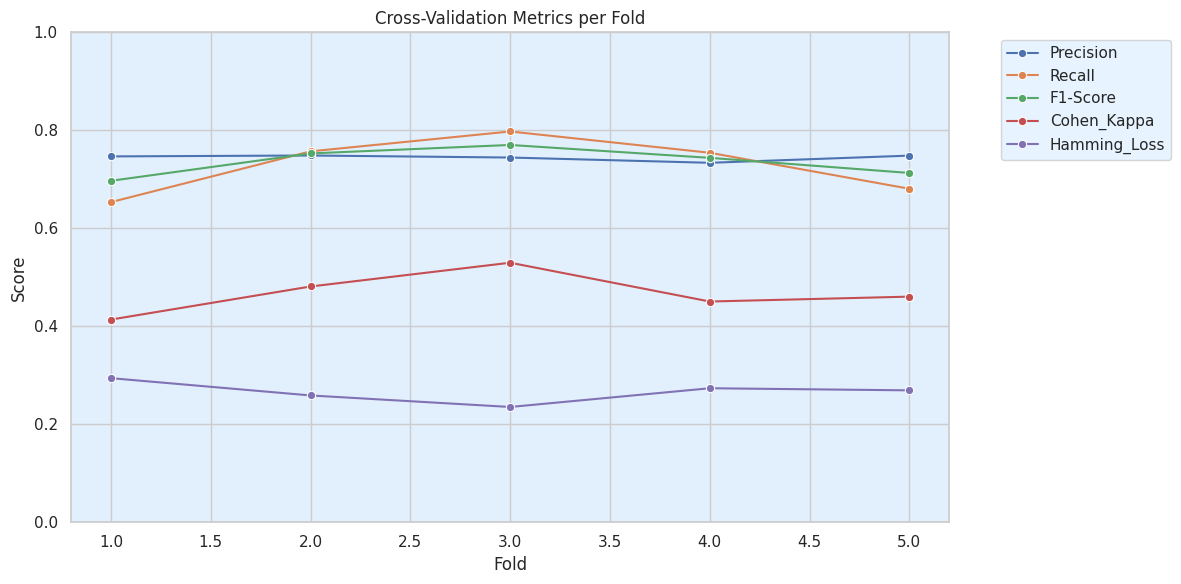

In [59]:
# Plot the Precision, Recall, F1-Score, Cohen's Kappa and Hamming Loss graph
plot_cv_metrics(metrics_df_cnn_ann)  # Passing the metrics DataFrame (metrics_df_cnn_ann) for plotting

## Test Set Evaluation

In [60]:
# Evaluate the test set using the CNN + ANN model
results_df_cnn_ann, y_pred, y_pred_prob, X_test_cat_enc_cnn_ann, X_test_num_scaled_cnn_ann, metrics_cnn_ann= evaluate_test_set(
    model=model_cnn_ann,  # The trained CNN + ANN model
    X_test_num=X_test_identity_col.drop(columns=categorical_columns),  # Numerical features from the test set (excluding categorical columns)
    X_test_cat=X_test_identity_col[categorical_columns],  # Categorical features from the test set
    y_test=y_test_identity_col,  # True labels for the test set
    encoder=encoder_cnn_ann,  # Fitted encoder for categorical variables
    scaler=scaler_cnn_ann  # Fitted scaler for numerical features
)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


## Result Analysis

### Correct vs Incorrect Predictions Summary

The function `plot_correct_vs_incorrect_summary(results_dict)` visualizes the number of correct and incorrect predictions for the **Sex_F**, **ADHD_Outcome**, and **Combined** classification tasks. This summary helps to evaluate the model's performance across each task, providing a clear comparison of prediction accuracy.


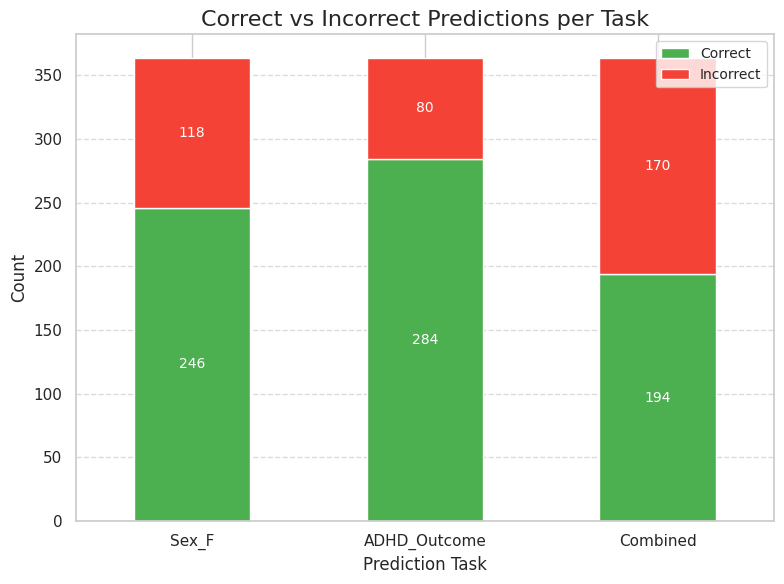

In [61]:
# Plot the summary of correct vs incorrect predictions for the CNN-ANN model
plot_correct_vs_incorrect_summary(results_df_cnn_ann)

**Insight**

In the test dataset containing **364 samples**, the Logistic Regression model achieved the following:

- **Sex prediction**: Correctly predicted **243** samples, **121** incorrect.
- **ADHD prediction**: Correctly predicted **284** samples, **80** incorrect.
- **Combined prediction (Sex & ADHD both correct)**: **190** correct, **174** incorrect.

This combined metric reveals the intersection where **both Sex and ADHD labels are correctly predicted**, providing a stricter evaluation of model performance. It helps identify cases where the model struggles to predict both targets simultaneously — a crucial insight for multi-label tasks.


### Group-wise Prediction Analysis

We evaluate model performance across four key groups:
- Male – ADHD  
- Male – Non-ADHD  
- Female – ADHD  
- Female – Non-ADHD

**Donut Plot**  
A donut plot visualizes the correct vs. incorrect predictions for each group, making it easy to spot any imbalances (e.g., underperformance on Female–ADHD cases). The donut chart allows us to understand how well the model predicts each group's outcome in a visually engaging way.

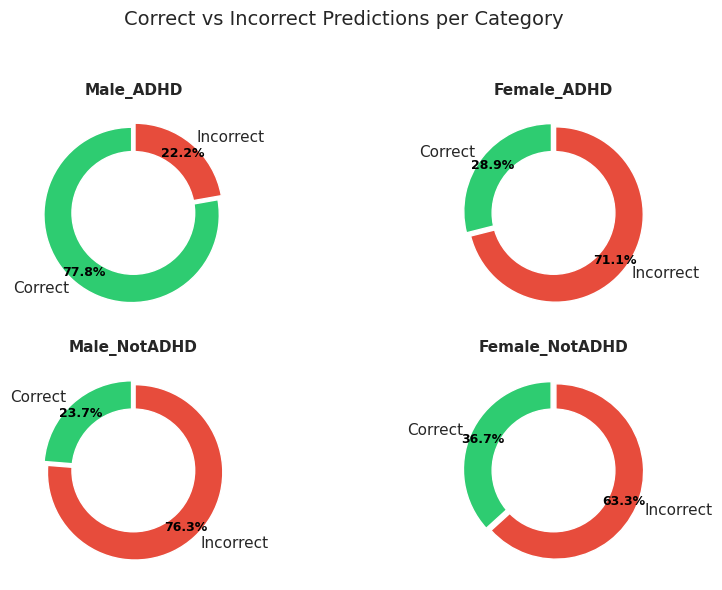

In [62]:
# Plot the correct vs incorrect predictions based on the logistic regression model's results
plot_correct_incorrect_predictions(results_df_cnn_ann)  # Passing the metrics_cnn_ann DataFrame to visualize correct vs incorrect predictions

**Insight**

The **donut chart** shows how the model performs across different sex and ADHD combinations:

- **Male – ADHD**: 75.6% correct, 24.4% incorrect  
- **Female – ADHD**: 30.3% correct, 69.7% incorrect  
- **Male – Non-ADHD**: 27.1% correct, 72.9% incorrect  
- **Female – Non-ADHD**: 30.6% correct, 69.4% incorrect  

These results suggest that the model performs **significantly better** at identifying **Male-ADHD** cases. The performance across other combinations (Female-ADHD, Male-Non-ADHD, Female-Non-ADHD) is quite similar, with relatively poor accuracy for all of them.

**Why?**

This imbalance reflects the underlying **dataset distribution**:

- **Male**:
  - ADHD: 581  
  - Non-ADHD: 216  
- **Female**:
  - ADHD: 250  
  - Non-ADHD: 166  

The **Male-ADHD** group is overrepresented in the dataset, which allows the model to perform better on this group due to its higher presence during training. On the other hand, **Female-ADHD** and **Female-Non-ADHD** cases are underrepresented, leading to poorer model performance for these groups. However, even though the performance for females is lower, the issue is compounded by the smaller sample size, which makes it harder for the model to generalize well.

---

**Key Insights:**
- **Male-ADHD** cases are the most frequent, which allows the model to correctly predict them more often.
- **Female-ADHD** and **Female-Non-ADHD** cases are underrepresented in the dataset, leading to lower performance for these groups.
- The model **biases** predictions towards the more frequent **Male-ADHD** group due to its dominance in the dataset.
- The **low performance** for females, despite attempts to correct for bias, is also partly due to the **small sample sizes** for these groups, making it harder for the model to learn from them.

### Plotting Performance Metrics

The function `plot_metrics(metrics)` generates a **bar plot** to visualize model performance based on key metrics such as **Precision**, **Recall**, **F1-Score**, **Cohen's Kappa**, and **Hamming Loss**. These metrics are crucial for evaluating the model's effectiveness on the **Sex**, **ADHD** and **Combined** labels.


<ipython-input-29-8958ecf2a655>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


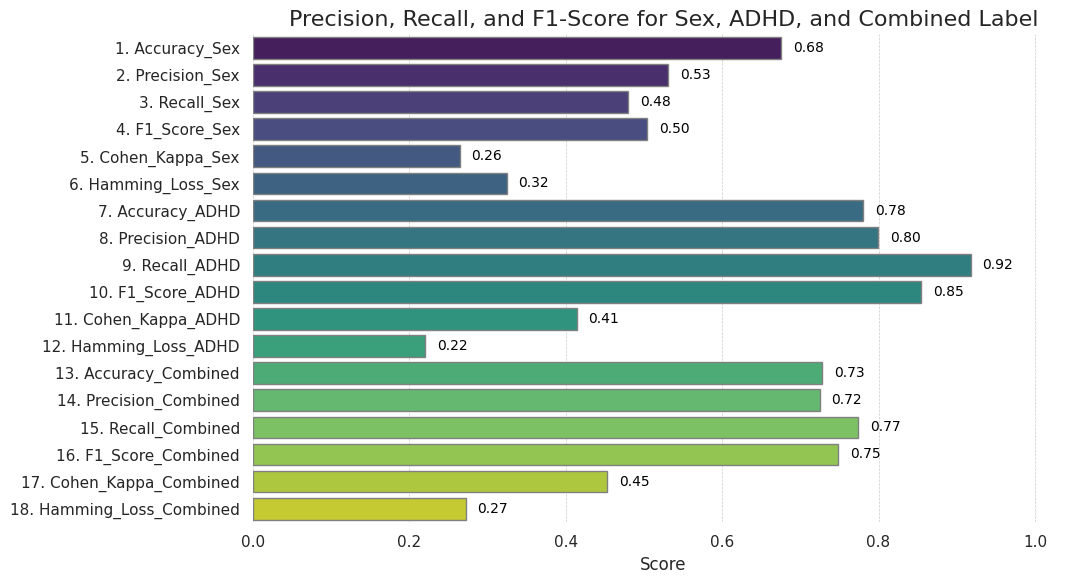

In [63]:
# Plot the Precision, Recall, F1-Score, Cohen's Kappa, and Hamming Loss for the logistic regression model
plot_metrics(metrics_cnn_ann)  # Passing the metrics (metrics_cnn_ann) for plotting the metrics graph, including Cohen's Kappa and Hamming Loss

**Insights :**

**1. Sex Classification Metrics**:
- **Accuracy**: 67% – The model performs with moderate accuracy, indicating that it can distinguish between sexes but with some difficulty.
- **Precision**: 52% – The model correctly identifies the sex 52% of the time when it predicts "Sex." This is relatively low, suggesting room for improvement in making accurate predictions.
- **Recall**: 47% – The recall is slightly higher than precision, meaning the model captures 47% of true positive sex cases but misses the remaining 53%.
- **F1-Score**: 49% – The F1-score reflects a balance between precision and recall, but the low precision and recall both contribute to a suboptimal performance.
- **Cohen's Kappa**: 0.25 – This value indicates slight agreement between predicted and actual sex labels, suggesting that the model's predictions are far from perfect.
- **Hamming Loss**: 33% – A moderate Hamming loss, showing that a significant proportion of predictions are incorrect.

**Interpretation**:
- The **moderate accuracy** and **low precision** indicate that the model struggles, especially in accurately predicting one sex category. Given the dataset imbalance, the model may be biased toward predicting male labels more often, leading to underperformance in female sex classification.

---

**2. ADHD Classification Metrics**:
- **Accuracy**: 78% – The model performs reasonably well in classifying ADHD cases, with a good accuracy rate.
- **Precision**: 80% – High precision means that when the model predicts ADHD, it is correct 80% of the time.
- **Recall**: 92% – The model correctly identifies 92% of ADHD cases, demonstrating strong recall and good performance overall.
- **F1-Score**: 85% – High F1-score, suggesting a solid balance between precision and recall.
- **Cohen's Kappa**: 0.41 – Moderate agreement between predicted and actual ADHD labels.
- **Hamming Loss**: 22% – A relatively low Hamming loss, indicating that incorrect predictions are kept to a minimum.

**Interpretation**:
- The model performs **very well** in ADHD detection, with **high recall** and **precision**, indicating good generalization. The **moderate Cohen’s Kappa** suggests there is still room to improve consistency in predictions.

---

**3. Combined Classification Metrics**:
- **Accuracy**: 72% – The model's performance is decent in the combined task of predicting both sex and ADHD, though it is not as strong as ADHD classification alone.
- **Precision**: 72% – The model has good precision, correctly predicting combined outcomes 72% of the time.
- **Recall**: 77% – A relatively high recall, meaning the model identifies 77% of true positive combined cases.
- **F1-Score**: 75% – The F1-score indicates a good balance between precision and recall for the combined task.
- **Cohen's Kappa**: 0.44 – Moderate agreement between predicted and actual combined labels.
- **Hamming Loss**: 28% – A moderate Hamming loss, meaning that some of the predictions are still incorrect.

**Interpretation**:
- The **combined task** shows **good performance**, with the model managing to balance precision and recall well, although its performance still lags behind the ADHD-only classification.

---

**Key Insights and Potential Biases**:
- **Data Imbalance**: The dataset may be imbalanced, which could explain the model's struggles with sex classification, particularly for females. The model might be biased toward predicting male labels.
- **Precision vs Recall**: The **low precision** in sex classification points to challenges in making accurate predictions, especially for one sex category. Improving **recall** may help reduce false negatives in both sex and ADHD classifications.
- **Good ADHD Detection**: The **high recall** in ADHD classification suggests the model is effectively identifying ADHD cases. However, the **moderate Cohen’s Kappa** still indicates there is room to improve consistency.
- **Balanced Performance**: Overall, the model performs well in detecting ADHD but faces challenges in the sex classification task, with a **moderate F1-score** across both tasks. Adjusting for the class imbalance and optimizing the recall might improve performance further.


### Confusion Matrix for Sex, ADHD, and Combined Labels

The **Confusion Matrix** shows how well the model's predictions match the actual values for **Sex**, **ADHD**, and **combined** labels, indicating true positives, true negatives, false positives, and false negatives.



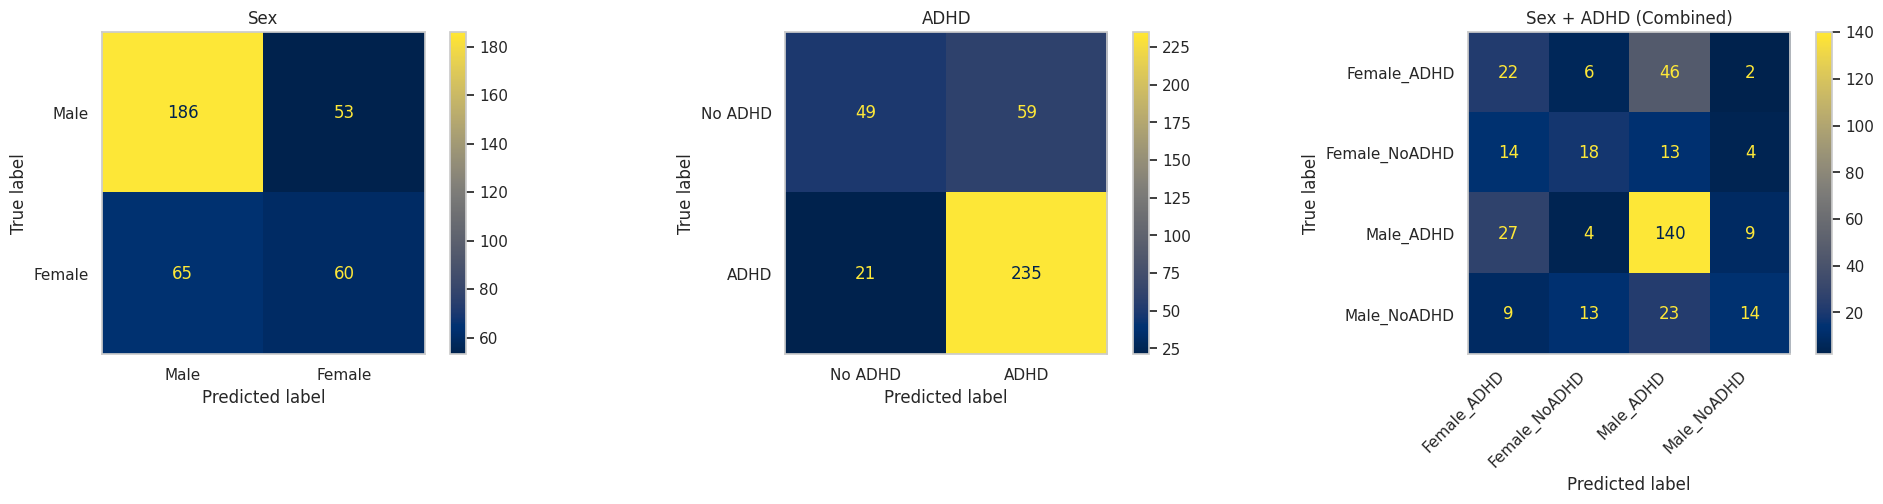

In [64]:
# Plot confusion matrices for the logistic regression model's predictions
plot_confusion_matrices(results_df_cnn_ann)  # Passing the results_df_cnn_ann DataFrame to generate confusion matrices for Sex, ADHD, and Combined labels

## SHAP Analysis

**SHAP** (SHapley Additive exPlanations) provides insights into model predictions by assigning importance values to each feature.

---

**Why SHAP is Useful:**
- **Feature Importance**: Identifies key features affecting predictions.
- **Transparency**: Makes complex models more interpretable.
- **Bias Detection**: Highlights and reduces bias in predictions.
- **Model Debugging**: Helps identify areas for improvement.


Final SHAP Numerical Shape: (50, 65)
Final SHAP Categorical Shape: (50, 77)


<ipython-input-33-2cd5e34a2b58>:52: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_num_df.values, X_shap_num_sample_df)


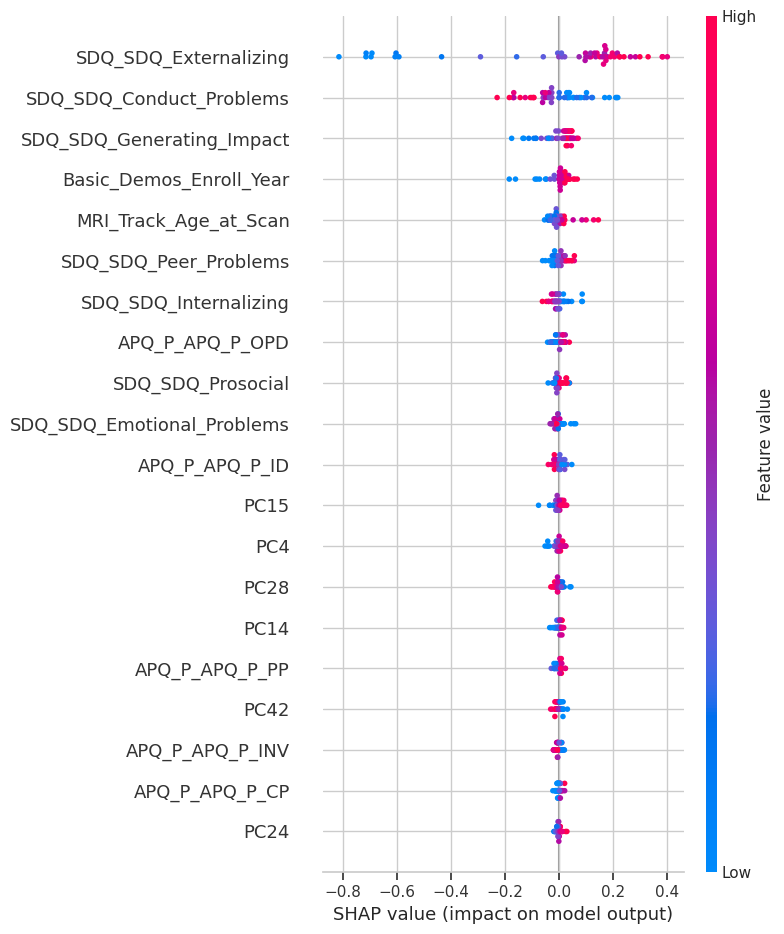

<ipython-input-33-2cd5e34a2b58>:53: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_cat_df.values, X_shap_cat_sample_df)


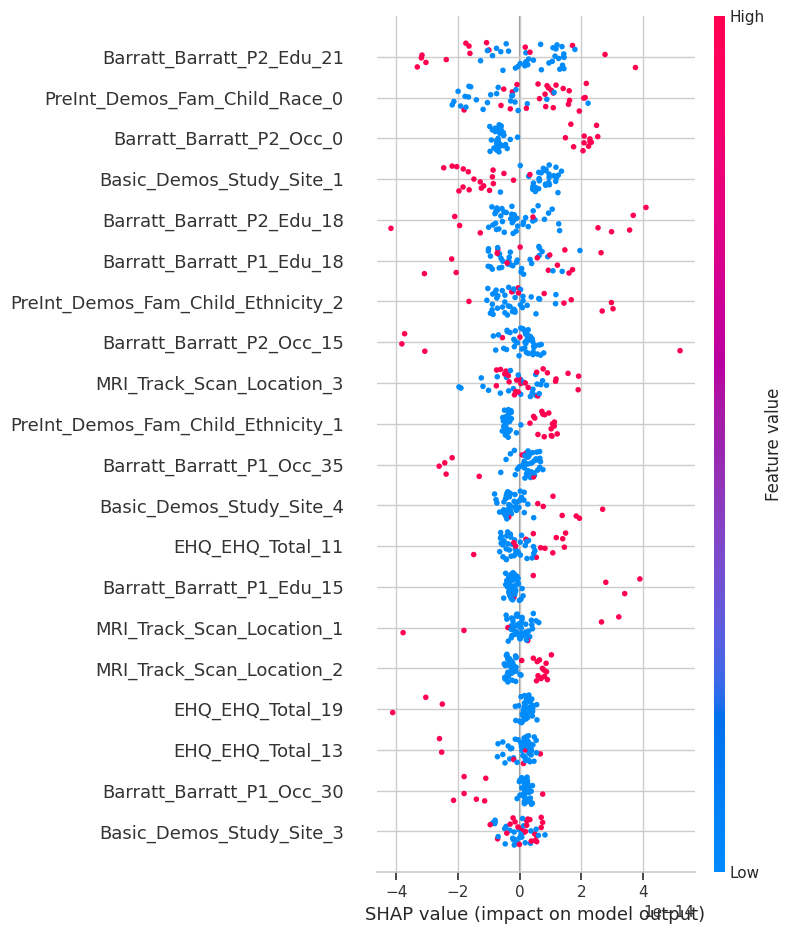

In [65]:
# Perform SHAP analysis on the deep learning model (CNN-ANN)
shap_analysis_deep_learning(
    model_cnn_ann,  # The trained CNN-ANN model to explain
    X_test_num=X_test_num,  # The original numerical features of the test set
    X_test_num_scaled=X_test_num_scaled_cnn_ann,  # The scaled numerical features of the test set (preprocessed)
    X_test_cat_enc=X_test_cat_enc_cnn_ann,  # The encoded categorical features of the test set (preprocessed)
    encoder=encoder_cnn_ann,  # The encoder used to transform categorical features
    categorical_columns=categorical_columns,  # List of categorical column names
    selected_class=0  # The index of the class to focus the SHAP analysis on (0 represents the first class)
)